# Risk Forecasting and Portfolio Tail Risk

In [4]:
import pandas as pd
import numpy as np
import os
from scipy.special import gamma as gamma_function
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t as t_dist
import matplotlib.dates as mdates
from pandas import Series
from matplotlib.patches import Patch
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from scipy.stats import t as t_dist, norm
from scipy.stats import gaussian_kde, skew, kurtosis
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

## Part I: Univariate Realized Volatility Modeling and Risk Forecasting

### 1.1: All RV Estimator

###### Important dataset features

We have 1-minute intraday data of high quality (SP500), with full sampling, which allows for precise estimation, therefore we adopted the All RV Estimator without relying on Sparse RV or Average RV estimators. Furthermore, the dataset includes night-time minutes (24h clock) and the overnight return is assigned to the following day: the first return after midnight captures overnight move and it is included in the RV and return of day t+1 consistent with Lecture 9-10 treatment.







In [5]:
# starting by importing the  data
df = pd.read_csv('/Users/G1x99/Desktop/Final Project/Data/SP_fullTime_1min.csv')

# displaying the dataset for visual inspection
print(df.head())
print(df['Date'].describe())

# removing rows where 'Open' is 0.00
# these rows represent missing or corrupted data in the intraday feed
df = df[df['Open'] != 0.00]

  Symbol        Date   Time    Open    High     Low   Close  Tick Count  \
0     SP  02/01/1983  09:01    0.00    0.00    0.00    0.00           0   
1     SP  02/01/1983  09:02    0.00    0.00    0.00    0.00           0   
2     SP  02/01/1983  09:03  145.29  145.29  145.25  145.25           2   
3     SP  02/01/1983  09:04  145.24  145.24  145.24  145.24           1   
4     SP  02/01/1983  09:05  145.24  145.24  145.24  145.24           0   

   Up Ticks  Down Ticks  Same Ticks     Date and Time  
0         0           0           0  02/01/1983 09:01  
1         0           0           0  02/01/1983 09:02  
2         0           1           1  02/01/1983 09:03  
3         0           1           0  02/01/1983 09:04  
4         0           0           0  02/01/1983 09:05  
count        3765662
unique          9460
top       07/27/2020
freq             415
Name: Date, dtype: object


In [6]:
# creation of the datetime column and sort
df["datetime"] = pd.to_datetime(df["Date and Time"], format="%m/%d/%Y %H:%M")
df = df.sort_values("datetime").reset_index(drop=True)

# extract calendar date (YYYY-MM-DD) — used for daily grouping
df["date"] = df["datetime"].dt.date

# Compute 1-minute log returns
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna(subset=["log_return"])  # remove first NaN

# grouping by date and computing the RV (includes overnight in t day)
# using the All RV Estimator
# RV_t = sum of squared intraday returns within day t
df_rv = df.groupby("date")["log_return"].apply(lambda x: np.sum(x**2)).reset_index(name="RV")

# last close of each day
df_daily_close = df.groupby(df["datetime"].dt.date)["Close"].last().reset_index(name="Close")

# computation of log daily returns
df_daily_close["daily_return"] = np.log(df_daily_close["Close"] / df_daily_close["Close"].shift(1))

# merging with df_rv
df_rv = df_rv.merge(df_daily_close[["datetime", "daily_return"]], left_on="date", right_on="datetime", how="left")
df_rv = df_rv.drop(columns="datetime")
df_rv = df_rv.dropna(subset=["daily_return"])  # removing first day (no daily return available)

# determining the realized volatility
df_rv["RVolatily"] = np.sqrt(df_rv["RV"])

# result
print(df_rv.head())
print(df_rv["RV"].describe())

         date        RV  daily_return  RVolatily
1  1983-02-02  0.000018      0.001887   0.004300
2  1983-02-03  0.000009      0.007235   0.003060
3  1983-02-04  0.000009      0.012879   0.002933
4  1983-02-07  0.000008      0.005391   0.002907
5  1983-02-08  0.000009     -0.008475   0.002939
count    9459.000000
mean        0.000067
std         0.000238
min         0.000000
25%         0.000011
50%         0.000023
75%         0.000056
max         0.009851
Name: RV, dtype: float64


### 1.2

In [7]:
# Take log
df_rv["RV_clean"] = df_rv["RV"].replace(0, np.nan)
df_rv["RV_clean"] = df_rv["RV_clean"].bfill()
df_rv["log_RV"] = np.log(df_rv["RV_clean"])
log_rv = np.log(df_rv["RV_clean"])

print(log_rv.describe())

count    9459.000000
mean      -10.519898
std         1.157841
min       -17.045642
25%       -11.424193
50%       -10.662706
75%        -9.780329
max        -4.620137
Name: RV_clean, dtype: float64


### ARMA(1, 1)

###### In-Sample

Estimated ARMA(1,1): phi = 0.9990, theta = -0.6661, sigma = 0.4880
Log-likelihood: -5308.85
AIC: 10623.70

In sample MSE: 0.2382

In sample MSE unlogged: 0.000000011976


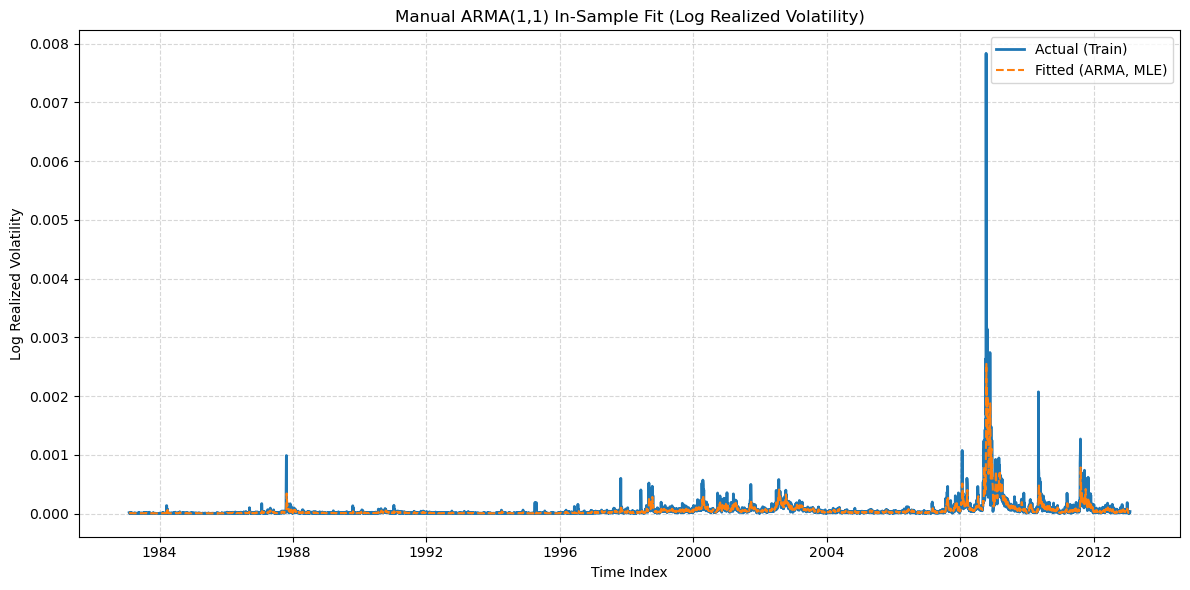

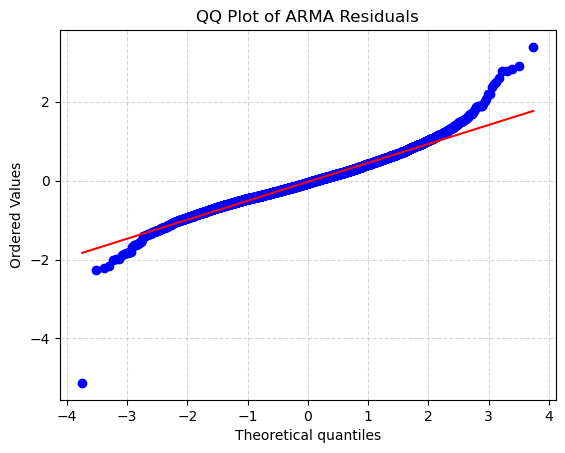

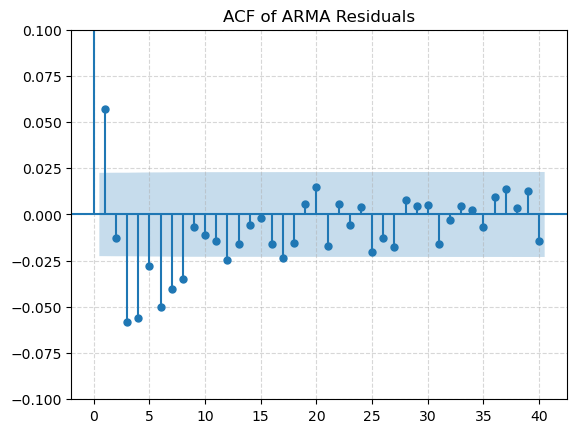

       lb_stat     lb_pvalue
10  122.994880  1.247153e-21
20  141.327645  2.833211e-20


In [8]:
# defining the train-test split (80% train, 20% test)
train_size = int(len(df_rv) * 0.8)
train = df_rv["log_RV"].iloc[:train_size]
train_np = train.values
test = df_rv["log_RV"].iloc[train_size:]
test_np = test.values

# defining the ARMA(1,1) log-likelihood function
# this will be minimized to estimate the model parameters
def arma11_loglik(params, series):
    phi, theta, sigma = params
    mu = 0  # assuming zero mean

    if np.abs(phi) >= 1 or np.abs(theta) >= 1 or sigma <= 0:
        return 1e10  # large penalty if constraints are violated

    T = len(series)
    e = np.zeros(T)
    fitted = np.zeros(T)

    # setting initial values
    fitted[0] = series[0]
    e[0] = 0

# recursion for ARMA(1,1)
    for t in range(1, T):
        fitted[t] = mu + phi * series[t - 1] + theta * e[t - 1]
        e[t] = series[t] - fitted[t]

# compute log-likelihood
    ll = -0.5 * T * np.log(2 * np.pi) - T * np.log(sigma) - (0.5 / sigma**2) * np.sum(e**2)
    return -ll  # negative because we minimize

# initial parameter guess: [phi, theta, sigma]
init_params = [0.5, 0.5, 1.0]  # phi, theta, sigma

# parameter estimation using L-BFGS-B optimizer
res = minimize(arma11_loglik, init_params, args=(train_np,), method='L-BFGS-B',
               bounds=[(-0.999, 0.999), (-0.999, 0.999), (1e-5, None)])

# extracting estimated parameters and computing AIC
phi_hat, theta_hat, sigma_hat = res.x
loglik = -res.fun
aic = 2 * 3 - 2 * loglik  # 3 parameters (phi, theta, sigma)

# displaying the estimation results
print(f"Estimated ARMA(1,1): phi = {phi_hat:.4f}, theta = {theta_hat:.4f}, sigma = {sigma_hat:.4f}")
print(f"Log-likelihood: {loglik:.2f}")
print(f"AIC: {aic:.2f}")

# re-computing fitted values and residuals using estimated parameters
T = len(train_np)
e = np.zeros(T)
fitted = np.zeros(T)

fitted[0] = train_np[0]
e[0] = 0

# recursion for fitted values
for t in range(1, T):
    fitted[t] = phi_hat * train_np[t - 1] + theta_hat * e[t - 1]
    e[t] = train_np[t] - fitted[t]

# evaluating in-sample forecast accuracy (MSE)
mse = mean_squared_error(train_np, fitted)
print(f"\nIn sample MSE: {mse:.4f}")
mse2 = mean_squared_error(np.exp(train_np), np.exp(fitted))
print(f"\nIn sample MSE unlogged: {mse2:.12f}")

# converting back from log(RV) to RV scale for plotting
train = np.exp(train_np)
fitted_nonnp = np.exp(fitted)

# getting the corresponding dates for the train set
train_dates = df_rv["date"].iloc[:train_size]

# plot of actual vs fitted realized volatility (train set)
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train, label="Actual (Train)", linewidth=2)
plt.plot(train_dates, fitted_nonnp, label="Fitted (ARMA, MLE)", linestyle="--")
plt.title("Manual ARMA(1,1) In-Sample Fit (Log Realized Volatility)")
plt.xlabel("Time Index")
plt.ylabel("Log Realized Volatility")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# QQ plot of ARMA residuals (to check for normality)
residuals = train_np - fitted
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of ARMA Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

# autocorrelation plot of residuals (ACF)
#lags_acf = np.arange(1, 41)
plot_acf(residuals, lags=40)
plt.ylim(-0.1, 0.1)
plt.title("ACF of ARMA Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

# Ljung-Box test on residuals (to test for remaining autocorrelation)
lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print(lb_test)

###### Out-of-Sample


Out-of-sample MSE: 0.4627

Out-of-sample MSE unlogged: 0.000000075751


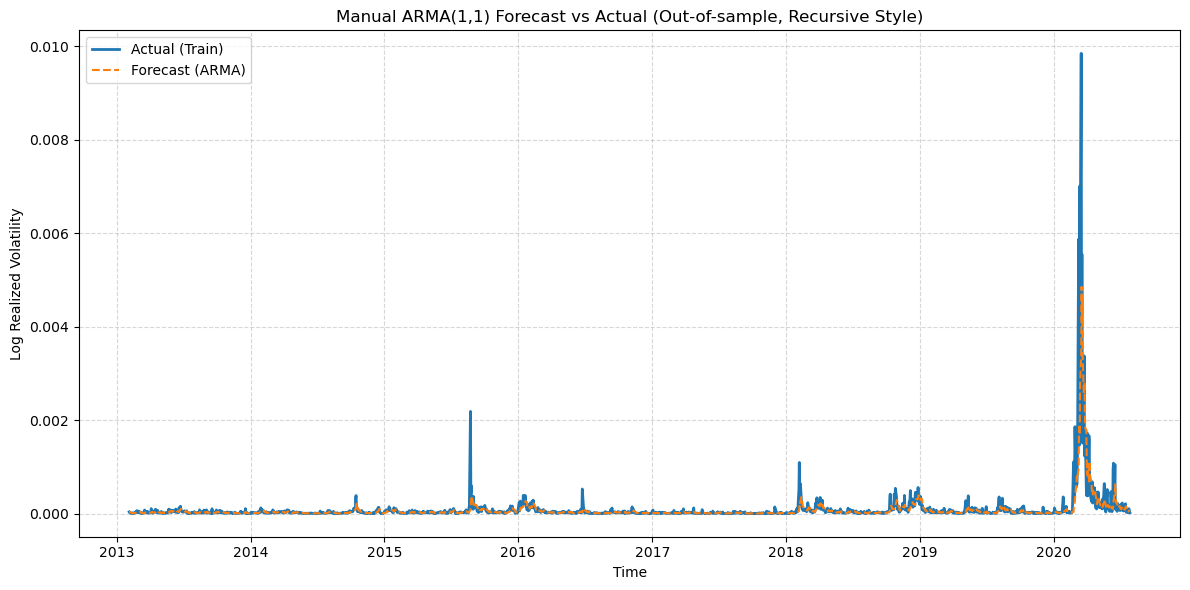

In [9]:
# starting from the last training value and assuming last residual is zero
last_train_value = train_np[-1]
last_resid = 0

# preparing arrays for the forecasts and residuals
T_test = len(test_np)
forecast = np.zeros(T_test)
resid = np.zeros(T_test)

# recursive forecasting over the test set
for t in range(T_test):
    if t == 0:
        # for the first step, using last train value and last residual
        forecast[t] = phi_hat * last_train_value + theta_hat * last_resid
    else:
        # for the following steps, using previous forecast and residual
        forecast[t] = phi_hat * test_np[t - 1] + theta_hat * resid[t - 1]

    # computing residual for the next step
    resid[t] = test_np[t] - forecast[t]

# evaluating out-of-sample forecast accuracy (MSE)
mse = mean_squared_error(test_np, forecast)
print(f"\nOut-of-sample MSE: {mse:.4f}")
mse2 = mean_squared_error(np.exp(test_np), np.exp(forecast))
print(f"\nOut-of-sample MSE unlogged: {mse2:.12f}")

# converting back from log(RV) to RV scale for plotting
test = np.exp(test_np)
forecast_nonnp = np.exp(forecast)

# getting the corresponding dates for the test set
test_dates = df_rv["date"].iloc[train_size:]

# plot of actual vs forecasted realized volatility (test set)
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test, label="Actual (Train)", linewidth=2)
plt.plot(test_dates, forecast_nonnp, label="Forecast (ARMA)", linestyle="--")
plt.title("Manual ARMA(1,1) Forecast vs Actual (Out-of-sample, Recursive Style)")
plt.xlabel("Time")
plt.ylabel("Log Realized Volatility")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()


### HAR-RV

###### In-Sample


In-sample MSE: 0.2344

In-sample MSE unlogged: 0.000000012668
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 1.182e+04
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:28:51   Log-Likelihood:                -5233.5
No. Observations:                7545   AIC:                         1.048e+04
Df Residuals:                    7541   BIC:                         1.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

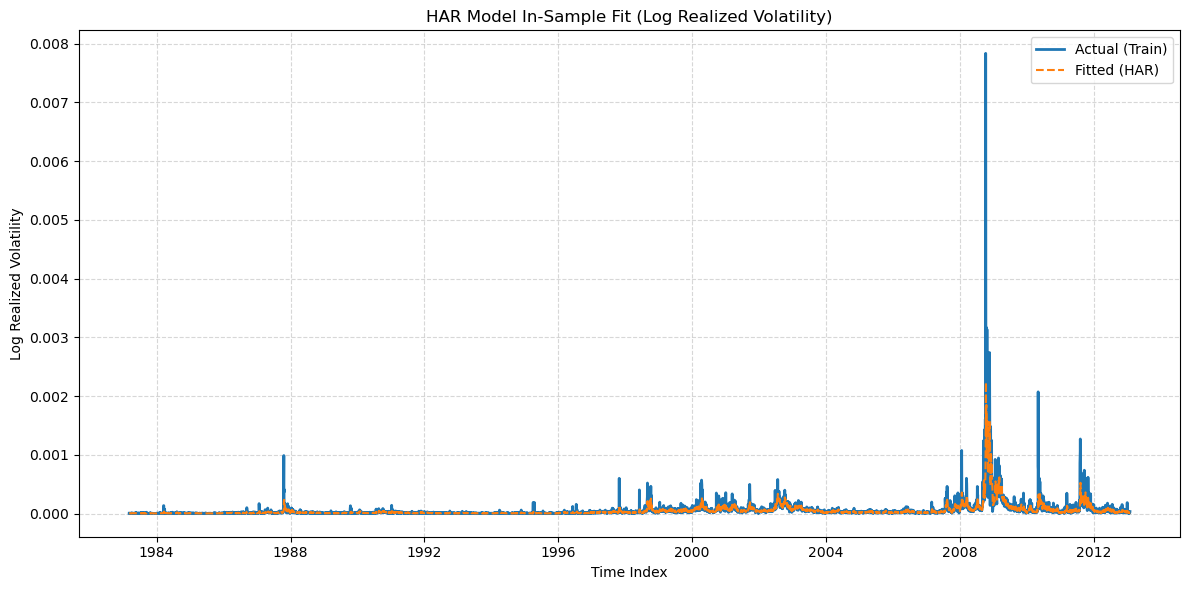

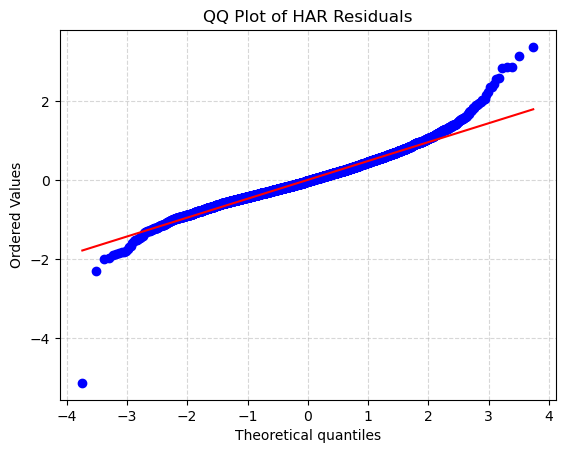

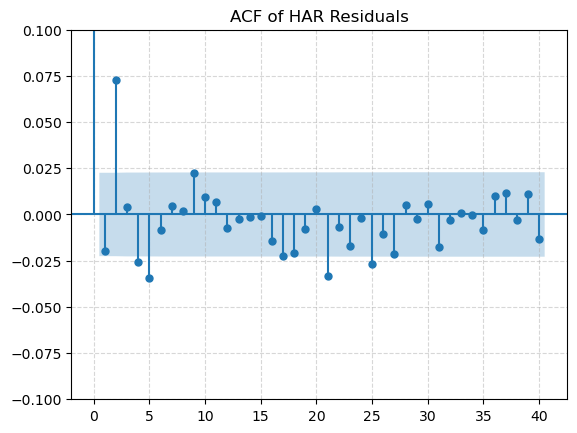


Ljung–Box test:
      lb_stat     lb_pvalue
10  61.971733  1.532072e-09
20  71.982707  8.615217e-08


In [10]:
# defining the train size (80% of sample)
train_size = int(len(df_rv) * 0.8)
train = df_rv["log_RV"].iloc[:train_size]
train_np = train.values  # numpy array
train_series = pd.Series(train)

# lagged features for HAR model
daily_lag = train_series.shift(1)
weekly_lag = train_series.rolling(5).mean().shift(1)
monthly_lag = train_series.rolling(22).mean().shift(1)

# dataset creation for OLS regression
df_har = pd.DataFrame({
    'y': train_series,
    'daily': daily_lag,
    'weekly': weekly_lag,
    'monthly': monthly_lag
}).dropna()

# OLS regression (HAR-RV)
X = sm.add_constant(df_har[['daily', 'weekly', 'monthly']])
y = df_har['y']
model = sm.OLS(y, X).fit()

# computation of fitted values and residuals
fitted = model.fittedvalues
residuals = y - fitted
mse = mean_squared_error(y, fitted)
mse2 = mean_squared_error(np.exp(y), np.exp(fitted))

# print of in-sample MSE and model summary
print(f"\nIn-sample MSE: {mse:.4f}")
print(f"\nIn-sample MSE unlogged: {mse2:.12f}")
print(model.summary())

# aligning the dates for plotting
train_dates = df_rv["date"].iloc[:train_size]
aligned_dates = train_dates[df_har.index]

# plot actual vs fitted realized volatility
plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, np.exp(y), label="Actual (Train)", linewidth=2)
plt.plot(aligned_dates, np.exp(fitted), label="Fitted (HAR)", linestyle="--")
plt.title("HAR Model In-Sample Fit (Log Realized Volatility)")
plt.xlabel("Time Index")
plt.ylabel("Log Realized Volatility")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# QQ Plot of HAR residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of HAR Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

# ACF of HAR residuals
plot_acf(residuals, lags=40)
plt.ylim(-0.1, 0.1)
plt.title("ACF of HAR Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

# Ljung-Box test for autocorrelation in HAR residuals
lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("\nLjung–Box test:")
print(lb_test)

###### Out-of-Sample


Out-of-sample MSE: 0.4627

Out-of-sample MSE unlogged: 0.000000094896


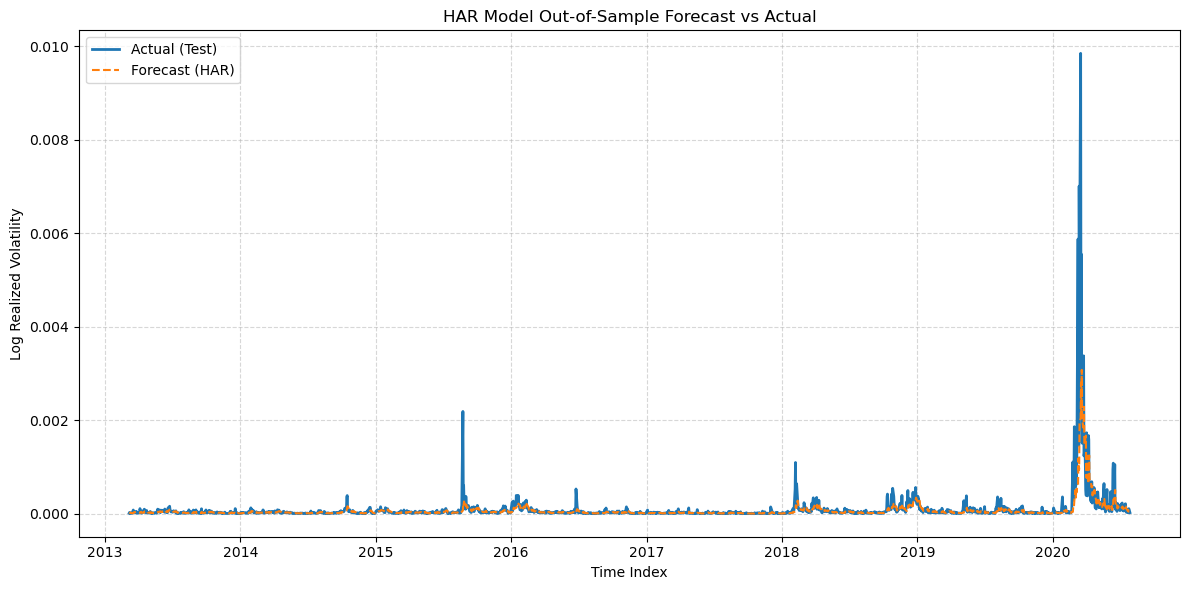

In [11]:
# defining the train size (80% of sample)
train_size = int(len(df_rv) * 0.8)
test = df_rv["log_RV"].iloc[train_size:]

test_series = pd.Series(test)

# lagged features for HAR model (test set)
daily_lag_test = test_series.shift(1)
weekly_lag_test = test_series.rolling(5).mean().shift(1)
monthly_lag_test = test_series.rolling(22).mean().shift(1)

# dataset creation for forecasting on test set
df_test = pd.DataFrame({
    'y': test_series,
    'daily': daily_lag_test,
    'weekly': weekly_lag_test,
    'monthly': monthly_lag_test
}).dropna()

# preparation of regressors for prediction
X_test = sm.add_constant(df_test[['daily', 'weekly', 'monthly']])
y_test = df_test['y']

# computation of HAR model forecasts
forecast_1d = model.predict(X_test)

# computation of out-of-sample MSE
mse_out = mean_squared_error(y_test, forecast_1d)
print(f"\nOut-of-sample MSE: {mse_out:.4f}")
mse_out2 = mean_squared_error(np.exp(y_test), np.exp(forecast_1d))
print(f"\nOut-of-sample MSE unlogged: {mse_out2:.12f}")

# aligning the dates for plotting
test_dates = df_rv["date"].iloc[train_size:]
aligned_dates = test_dates[df_test.index]

# plot of actual vs forecasted realized volatility (test set)
plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, np.exp(y_test), label="Actual (Test)", linewidth=2)
plt.plot(aligned_dates, np.exp(forecast_1d), label="Forecast (HAR)", linestyle="--")
plt.title("HAR Model Out-of-Sample Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Log Realized Volatility")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

### HAR-RV-CJ

###### In-Sample


In-sample MSE (HAR-RV-CJ): 0.2328

In-sample MSE unlogged (HAR-RV-CJ): 0.000000014662
                            OLS Regression Results                            
Dep. Variable:                 log_RV   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     3969.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        01:29:00   Log-Likelihood:                -5210.7
No. Observations:                7549   AIC:                         1.044e+04
Df Residuals:                    7539   BIC:                         1.051e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

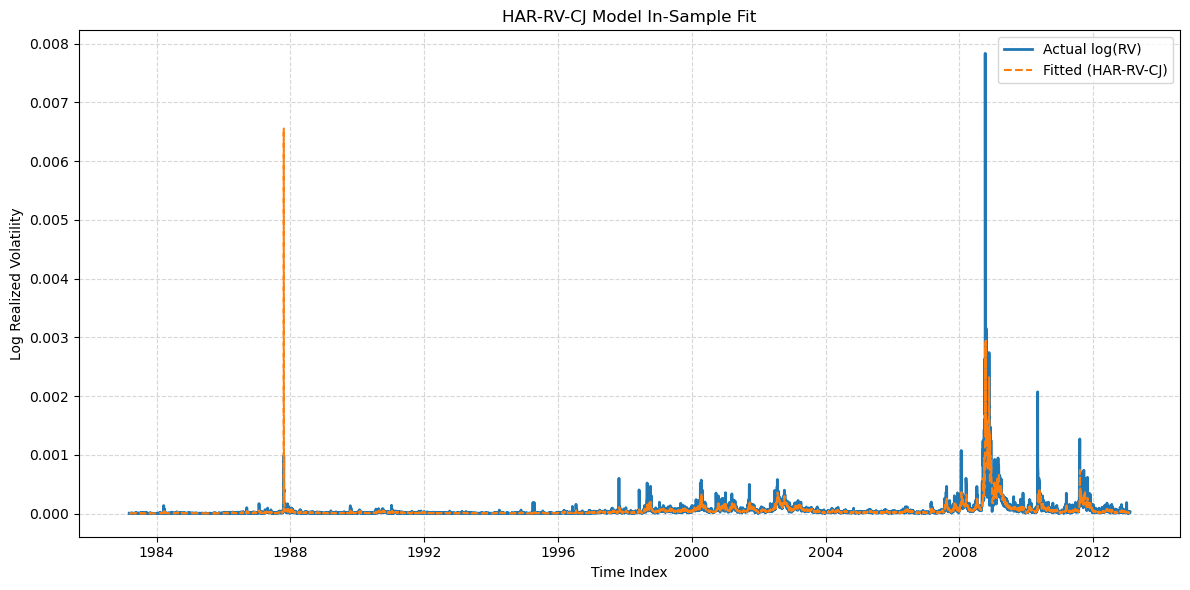

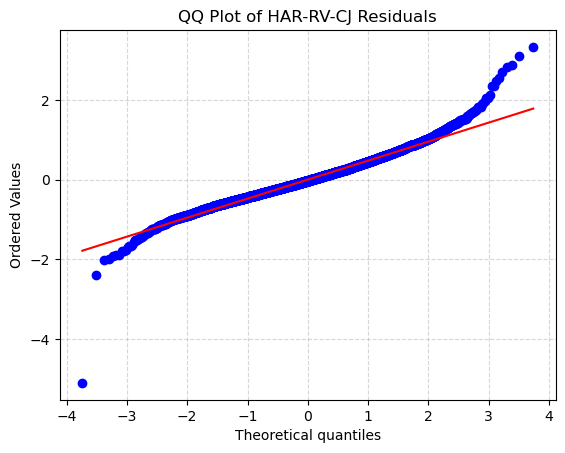

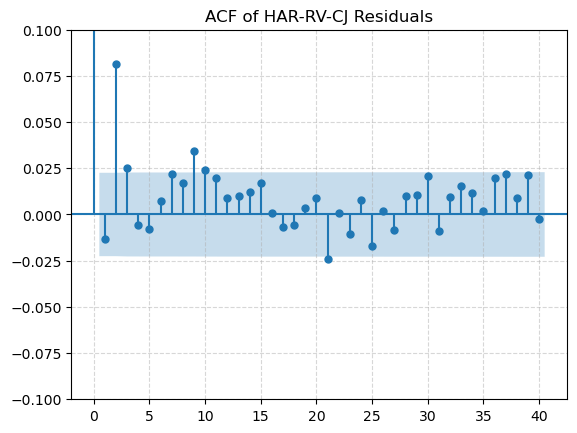


Ljung Box test:
      lb_stat     lb_pvalue
10  76.932245  1.998893e-12
20  85.800996  3.981452e-10


In [12]:
# constant for bipower variation calculation
mu1 = np.sqrt(2 / np.pi)

# creation of datetime column and sorting the data
df["datetime"] = pd.to_datetime(df["Date and Time"], format="%m/%d/%Y %H:%M")
df = df[df["Open"] != 0.00].sort_values("datetime").reset_index(drop=True)

# computation of log prices and returns
df["log_price"] = np.log(df["Close"])
df["ret"] = df["log_price"].diff()

# squared returns and absolute returns
df["r_sq"] = df["ret"] ** 2
df["abs_ret"] = df["ret"].abs()

# lagged absolute returns and their product
df["abs_ret_lag"] = df["abs_ret"].shift(1)
df["abs_prod"] = df["abs_ret"] * df["abs_ret_lag"]

# extraction of date for grouping
df["date"] = df["datetime"].dt.date

# computation of daily RV, BV and jump component
rv_daily = df.groupby("date")["r_sq"].sum()
bv_daily = df.groupby("date")["abs_prod"].sum() * (1 / mu1**2)
jump_daily = (rv_daily - bv_daily).clip(lower=0)

# computation of daily close and daily return
daily_close = df.groupby("date")["Close"].last()
daily_return = np.log(daily_close / daily_close.shift(1))

# assembly of the final dataframe
df_rv = pd.DataFrame({
    "RV": rv_daily,
    "BV": bv_daily,
    "jump": jump_daily,
    "Close": daily_close,
    "daily_return": daily_return
}).dropna()

# cleaning RV column and computing log(RV)
df_rv["RV_clean"] = df_rv["RV"].replace(0, np.nan)
df_rv["RV_clean"] = df_rv["RV_clean"].bfill()
df_rv["log_RV"] = np.log(df_rv["RV_clean"])

# creation of jump features
df_rv["log_J_1"] = np.log(1 + df_rv["jump"].shift(1))
df_rv["log_J_5"] = np.log(1 + df_rv["jump"].rolling(5).mean().shift(1))
df_rv["log_J_22"] = np.log(1 + df_rv["jump"].rolling(22).mean().shift(1))

# computation of continuous component
df_rv["C_1"] = np.log(df_rv["RV_clean"].rolling(1).mean().shift(1)-df_rv["jump"].rolling(1).mean().shift(1))
df_rv["C_5"] = np.log(df_rv["RV_clean"].rolling(5).mean().shift(1)-df_rv["jump"].rolling(5).mean().shift(1))
df_rv["C_22"] = np.log(df_rv["RV_clean"].rolling(22).mean().shift(1)-df_rv["jump"].rolling(22).mean().shift(1))

# computation of downside risk
df_rv["ret_neg_sq"] = df_rv["daily_return"].apply(lambda x: x**2 if x < 0 else 0)
df_rv["downside_1"] = df_rv["ret_neg_sq"].rolling(1).mean().shift(1)
df_rv["downside_5"] = df_rv["ret_neg_sq"].rolling(5).mean().shift(1)
df_rv["downside_22"] = df_rv["ret_neg_sq"].rolling(22).mean().shift(1)

# dropping missing values for final estimation dataset
df_rv = df_rv.dropna(subset=["log_RV", "downside_1", "downside_5", "downside_22", "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"])

# splitting the dataset into train and test
split_idx = int(len(df_rv) * 0.8)
df_train = df_rv.iloc[:split_idx]
df_test = df_rv.iloc[split_idx:]

# preparation of HAR-RV-CJ regression dataset
df_har_cj = df_train[["log_RV","downside_1", "downside_5", "downside_22", "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"]].dropna()

# OLS regression (HAR-RV-CJ model)
X = sm.add_constant(df_har_cj[["downside_1", "downside_5", "downside_22", "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"]])
y = df_har_cj["log_RV"]
model = sm.OLS(y, X).fit()

# computation of fitted values and residuals
fitted = model.fittedvalues
residuals = y - fitted
mse = mean_squared_error(y, fitted)
mse_2 = mean_squared_error(np.exp(y), np.exp(fitted))

# print of in-sample MSE and model summary
print(f"\nIn-sample MSE (HAR-RV-CJ): {mse:.4f}")
print(f"\nIn-sample MSE unlogged (HAR-RV-CJ): {mse_2:.12f}")
print(model.summary())

# plot of actual vs fitted log(RV)
plt.figure(figsize=(12, 6))
plt.plot(df_har_cj.index, np.exp(y), label="Actual log(RV)", linewidth=2)
plt.plot(df_har_cj.index, np.exp(fitted), label="Fitted (HAR-RV-CJ)", linestyle="--")
plt.title("HAR-RV-CJ Model In-Sample Fit")
plt.xlabel("Time Index")
plt.ylabel("Log Realized Volatility")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of HAR-RV-CJ Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

# ACF of residuals
plot_acf(residuals, lags=40)
plt.ylim(-0.1, 0.1)
plt.title("ACF of HAR-RV-CJ Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

# Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("\nLjung Box test:")
print(lb_test)


Note: the observed spike around 1987 is due to extreme jumps affecting the jump component coefficients. This is a known issue in HAR-RV-CJ models and can be mitigated with robust regression techniques.”

###### Out-of-Sample


Out-of-sample MSE (HAR-RV-CJ): 0.5431

Out-of-sample MSE unlogged (HAR-RV-CJ): 0.000003301025


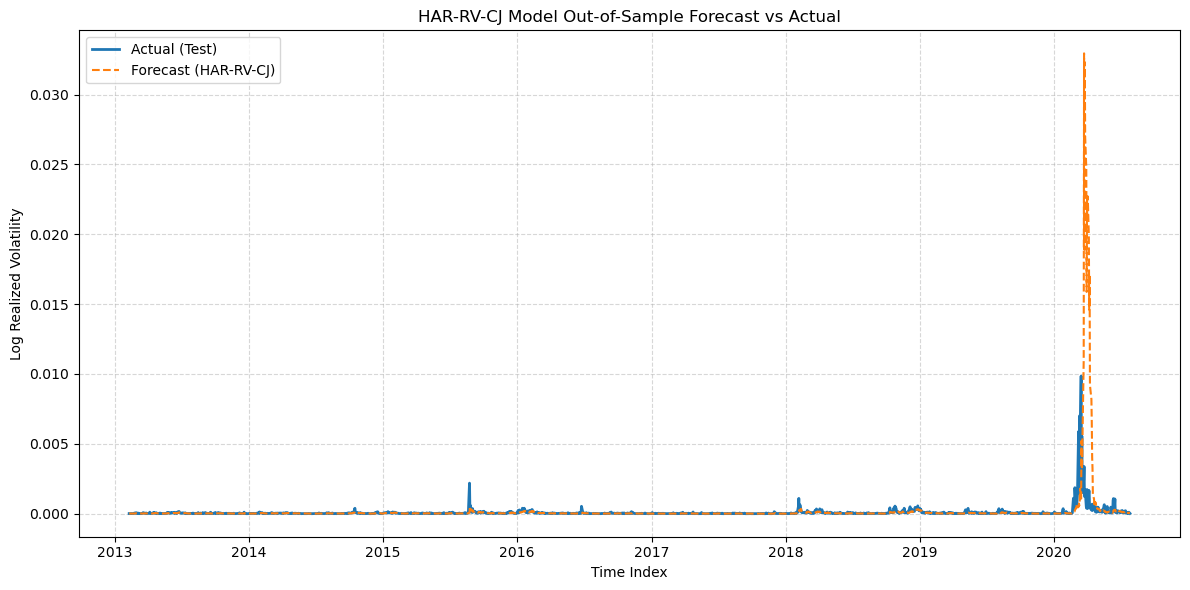

In [13]:
# creation of target variable for test set
df_test["y"] = df_test["log_RV"]

# preparation of HAR-RV-CJ features for test set
df_test_final = df_test[["y", "downside_1", "downside_5", "downside_22", "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"]].dropna()

# preparation of regressors for prediction
X_test = sm.add_constant(df_test_final[["downside_1", "downside_5", "downside_22", "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"]])
y_test = df_test_final["y"]

# computation of HAR-RV-CJ forecasts
forecast = model.predict(X_test)

# computation of out-of-sample MSE
mse_out = mean_squared_error(y_test, forecast)
print(f"\nOut-of-sample MSE (HAR-RV-CJ): {mse_out:.4f}")
mse_out2 = mean_squared_error(np.exp(y_test), np.exp(forecast))
print(f"\nOut-of-sample MSE unlogged (HAR-RV-CJ): {mse_out2:.12f}")

# plot of actual vs forecasted log(RV) on test set
plt.figure(figsize=(12, 6))
plt.plot(df_test_final.index, np.exp(y_test), label="Actual (Test)", linewidth=2)
plt.plot(df_test_final.index, np.exp(forecast), label="Forecast (HAR-RV-CJ)", linestyle="--")
plt.title("HAR-RV-CJ Model Out-of-Sample Forecast vs Actual")
plt.xlabel("Time Index")
plt.ylabel("Log Realized Volatility")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()


### Realised-GARCH with a linear specification

###### In-Sample


Log-likelihood (paper form): 96327.1316

Optimal parameters:
  omega      = 1.32e-05
  beta       = 0.6167
  gamma      = 0.6456
  xi         = -1.136e-05
  phi        = 0.5279
  tau1       = -0.0000
  tau2       = 0.0000
  sigma_u2   = 1.21e-08

Persistence (beta + gamma·phi) = 0.9575
Long-run variance              = 0.00013863
AIC = -192638.26
MSE (Forecast vs RV): 0.000000018712
Mean QLIKE: -8.975176370331


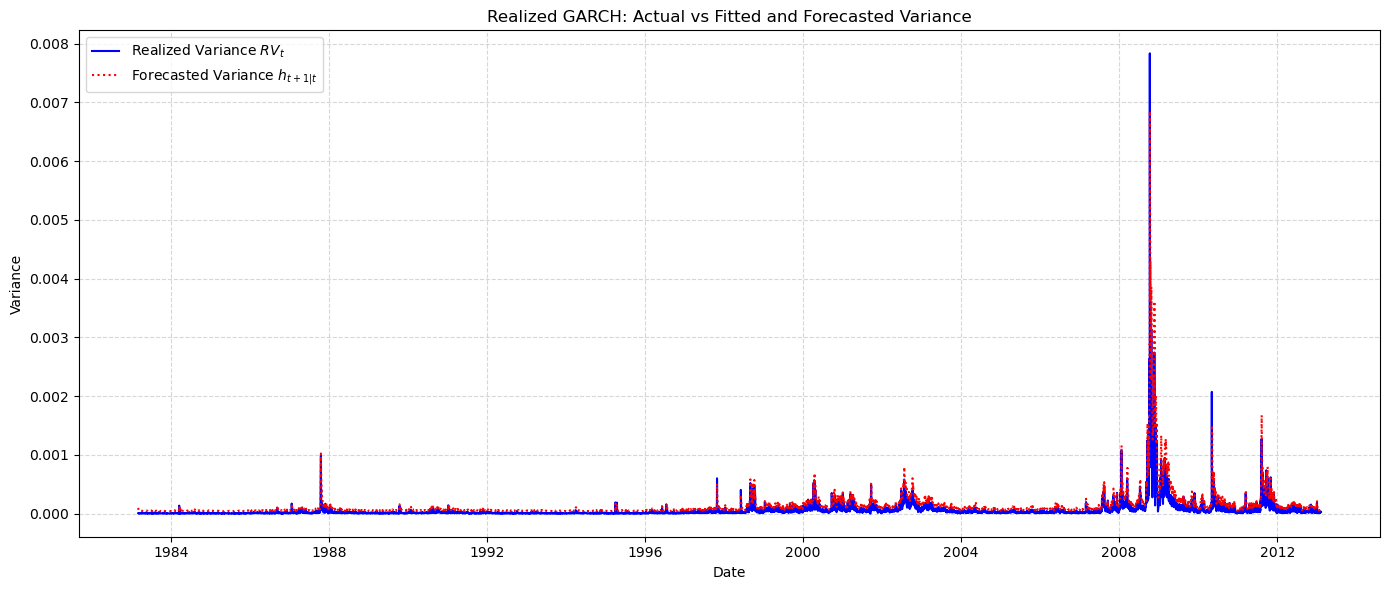

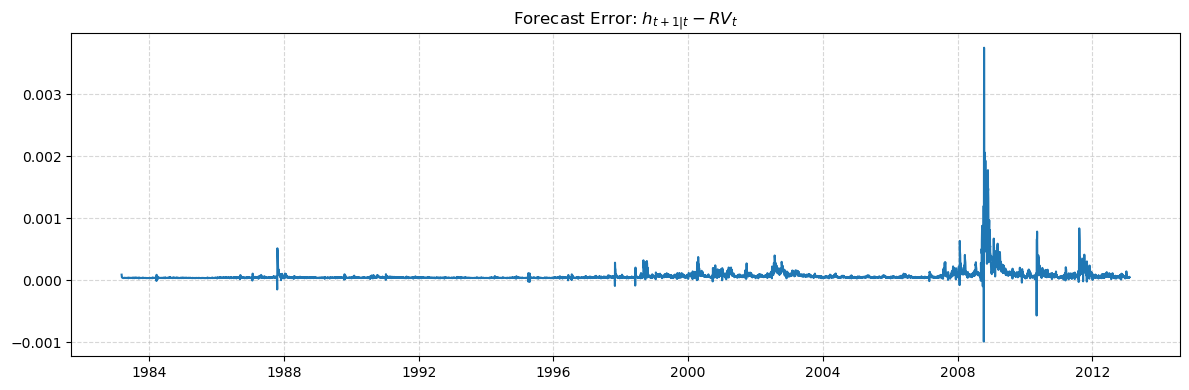

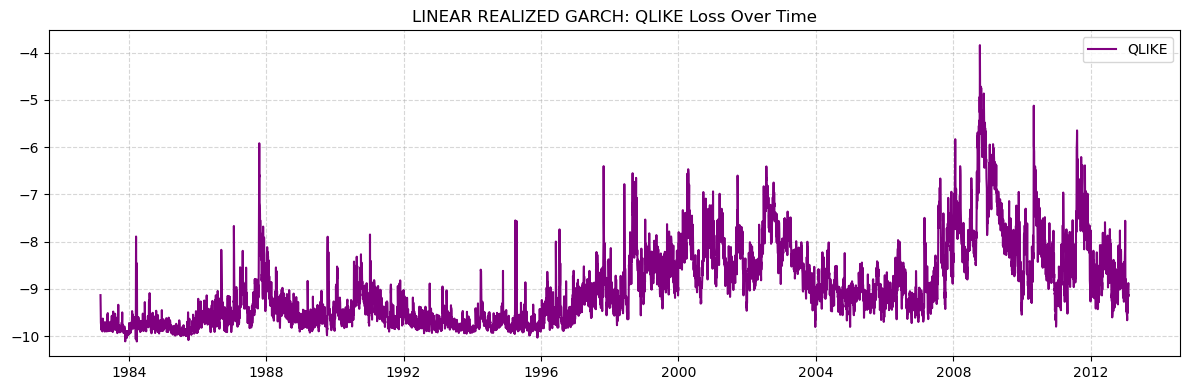

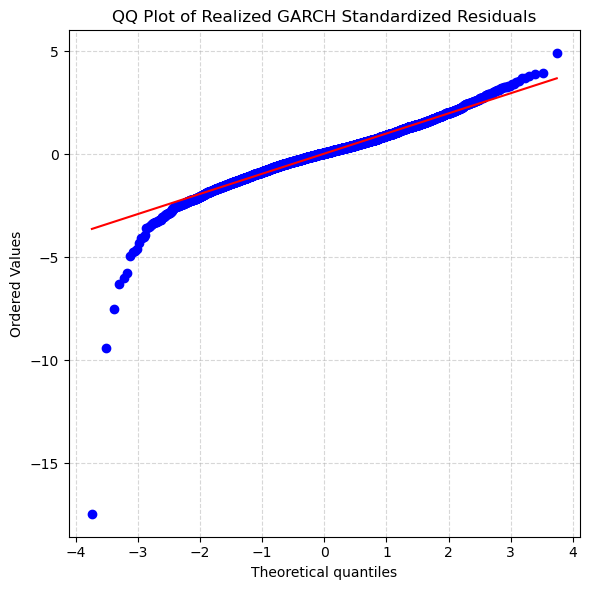

<Figure size 1000x500 with 0 Axes>

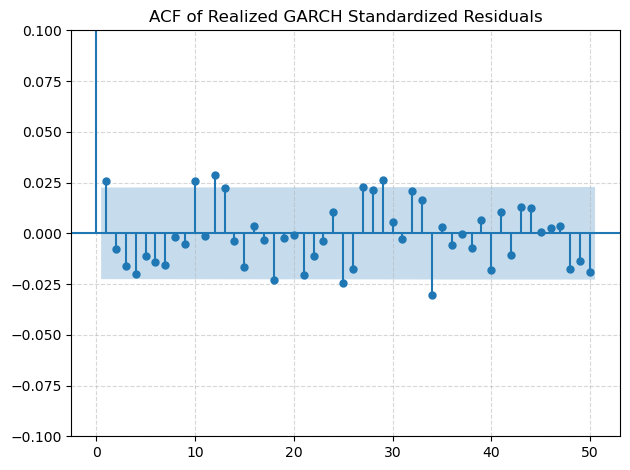


Ljung-Box test on Realized GARCH standardized residuals:
      lb_stat  lb_pvalue
10  20.039295   0.028883
20  36.719257   0.012642


In [14]:
# definition of train size (80% of sample)
train_size = int(len(df_rv) * 0.8)
R_test_before = df_rv["daily_return"].iloc[:train_size]
R_test = R_test_before.values

RV_test_before = df_rv["RV"].iloc[:train_size]
RV_test = RV_test_before.values

# definition of Realized GARCH log-likelihood calculator
def realised_garch_calculator(parameters, return_data, realised_variance):
    (omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2) = parameters

    # parameter constraints
    if (
        omega <= 0 or sigma_u2 <= 0 or phi <= 0
        or beta < 0 or beta >= 1
        or gamma < 0
    ):
        return {"loglik": -1e9}

    return_data = np.asarray(return_data, dtype=float)
    realised_variance = np.asarray(realised_variance, dtype=float)
    T = return_data.size

    h_path = np.empty(T + 1)
    z_path = np.empty(T)

    # initialization
    h_path[0] = return_data.var(ddof=1)
    z_path[0] = return_data[0] / np.sqrt(h_path[0])

    # recursion for variance path
    for t in range(1, T):
        h_path[t] = omega + beta * h_path[t - 1] + gamma * realised_variance[t - 1]
        if h_path[t] <= 0:
            return {"loglik": -1e9}
        z_path[t] = return_data[t] / np.sqrt(h_path[t])

    # one-step ahead forecast for last point
    h_path[T] = omega + beta * h_path[T - 1] + gamma * realised_variance[T - 1]

    # measurement equation residual
    leverage_term = tau1 * z_path + tau2 * (z_path**2 - 1.0)
    measurement_error = realised_variance - (xi + phi * h_path[:T] + leverage_term)

    # log-likelihood calculation
    loglik = -0.5 * (
        np.log(h_path[:T]).sum() +
        (return_data**2 / h_path[:T]).sum() +
        T * np.log(sigma_u2) +
        (measurement_error**2).sum() / sigma_u2
    )

    return {
        "loglik": loglik,
        "var": h_path,
        "z": z_path,
        "u": measurement_error
    }

# definition of negative log-likelihood for minimization
def neg_realised_garch_calculator(parameters, return_data, realised_variance):
    return -realised_garch_calculator(parameters, return_data, realised_variance)["loglik"]

# starting values for optimization
starting_values = np.array([
    1e-6, 0.90, 0.05, 0.0, 0.80, 0.0, 0.0, 1e-8
])

# parameter bounds
parameter_bounds = [
    (1e-8, 1),         # omega
    (0.01, 0.98),      # beta
    (0.01, 0.98),      # gamma
    (-5, 5),           # xi
    (0.05, 2.0),       # phi
    (-3.0, 3.0),       # tau1
    (-3.0, 3.0),       # tau2
    (1e-8, 1e-2)       # sigma_u2
]

# optimization using Nelder-Mead
result = minimize(
    neg_realised_garch_calculator,
    starting_values,
    args=(R_test, RV_test),
    bounds=parameter_bounds,
    method="Nelder-Mead"
)

# extraction of estimated parameters
(omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2) = result.x
loglik = -result.fun
persistence = beta + gamma * phi
long_run_var = np.nan if 1 - persistence <= 0 else (omega + gamma * xi) / (1 - persistence)

# model summary
print(f"\nLog-likelihood (paper form): {loglik:.4f}\n")
print("Optimal parameters:")
print(f"  omega      = {omega:.2e}")
print(f"  beta       = {beta:.4f}")
print(f"  gamma      = {gamma:.4f}")
print(f"  xi         = {xi:.3e}")
print(f"  phi        = {phi:.4f}")
print(f"  tau1       = {tau1:.4f}")
print(f"  tau2       = {tau2:.4f}")
print(f"  sigma_u2   = {sigma_u2:.2e}")
print(f"\nPersistence (beta + gamma·phi) = {persistence:.4f}")
print("Long-run variance              =", f"{long_run_var:.8f}" if not np.isnan(long_run_var) else "undefined")

# computation of AIC
k = len(result.x)
T = len(R_test)
aic = 2 * k - 2 * loglik
print(f"AIC = {aic:.2f}")

# extraction of variance path
garch_out = realised_garch_calculator(result.x, R_test, RV_test)
h_t = garch_out["var"][:-1]
h_t1 = garch_out["var"][1:]
rv = RV_test[:len(h_t)]

# computation of forecast errors and QLIKE
forecast_error = h_t1 - rv
qlike = np.log(h_t1) + rv / h_t1
mae = np.abs(forecast_error)

mse_forecast = np.mean((h_t1 - rv)**2)
qlike_loss = np.mean(qlike)

# print of forecast performance
print(f"MSE (Forecast vs RV): {mse_forecast:.12f}")
print(f"Mean QLIKE: {qlike_loss:.12f}")

# date index for plotting
date_index = df_rv.index[:len(h_t)]

# plot of variance path: realized vs forecasted
plt.figure(figsize=(14, 6))
plt.plot(date_index, rv, label="Realized Variance $RV_t$", color="blue")
plt.plot(date_index, h_t1, label="Forecasted Variance $h_{t+1|t}$", linestyle=":", color="red")
plt.title("Realized GARCH: Actual vs Fitted and Forecasted Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# plot of forecast errors
plt.figure(figsize=(12, 4))
plt.plot(date_index, forecast_error)
plt.title("Forecast Error: $h_{t+1|t} - RV_t$")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# plot of QLIKE over time
plt.figure(figsize=(12, 4))
plt.plot(date_index, qlike, color="purple", label="QLIKE")
plt.title("LINEAR REALIZED GARCH: QLIKE Loss Over Time")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.legend()
plt.show()

# extraction of standardized residuals
residuals = garch_out["z"]

# QQ Plot of standardized residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Realized GARCH Standardized Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# ACF plot of standardized residuals
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=50, alpha=0.05)
plt.ylim(-0.1, 0.1)
plt.title("ACF of Realized GARCH Standardized Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# Ljung-Box test on standardized residuals
lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("\nLjung-Box test on Realized GARCH standardized residuals:")
print(lb_test)


##### Out-of-Sample


OUT-OF-SAMPLE Metrics (LINEAR REALIZED GARCH):
Out-of-sample MSE: 0.000000034851
Forecast bias (mean diff): -0.000000000000
Out-of-sample QLIKE mean: -9.103719737376
Out-of-sample MAE mean: 0.000040489947


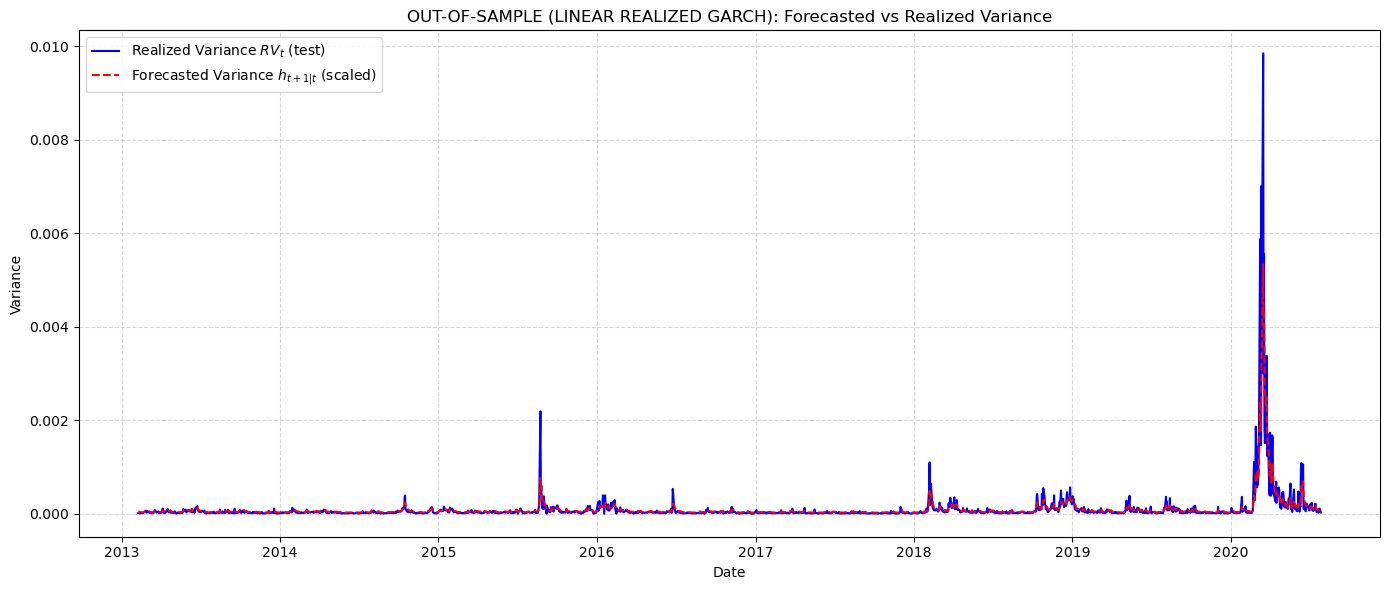

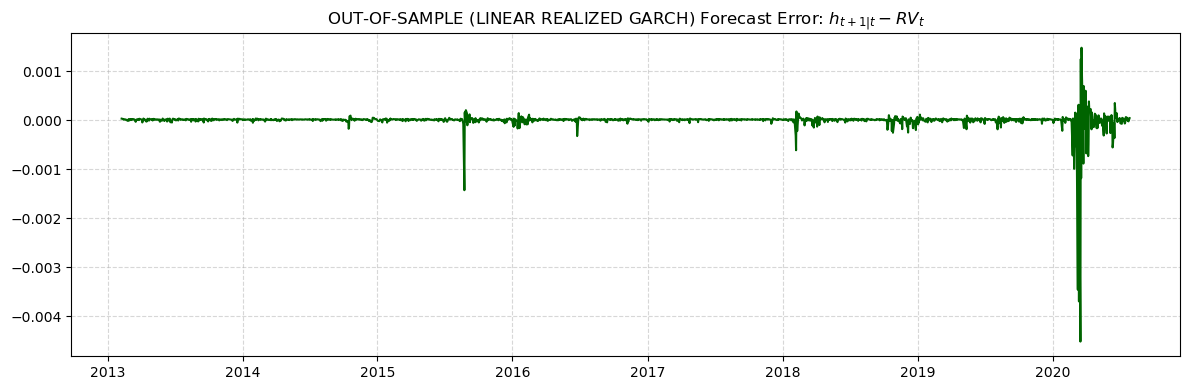

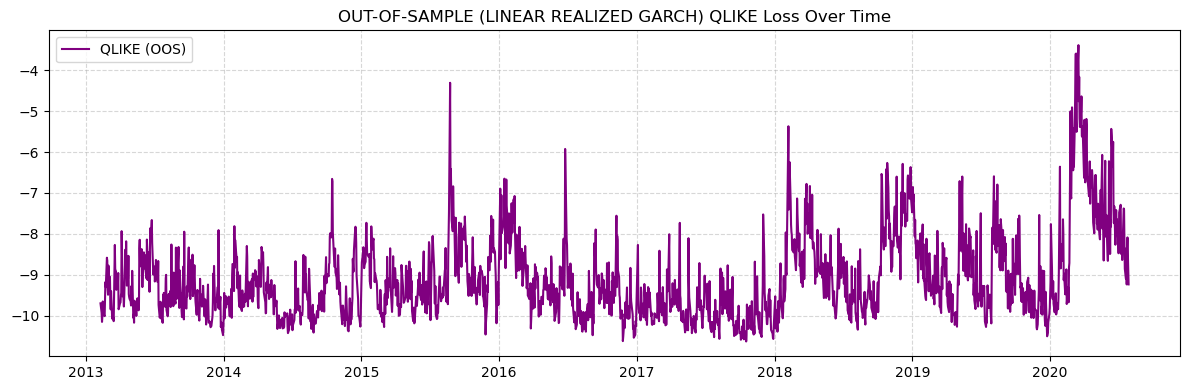

In [15]:
# definition of split point (80% train, 20% test)
split = int(len(df_rv) * 0.8)

# extraction of training returns and RV
train_size = int(len(df_rv) * 0.8)
R_test_before = df_rv["daily_return"].iloc[:train_size]
train_data = R_test_before.values

RV_test_before = df_rv["RV"].iloc[:train_size]
train_rv = RV_test_before.values

# extraction of test returns and RV
R_actual_test_before = df_rv["daily_return"].iloc[train_size:]
test_data = R_actual_test_before.values

RV_actual_test_before = df_rv["RV"].iloc[train_size:]
test_rv = RV_actual_test_before.values

# parameters estimated from in-sample optimization
params = result.x  # results from previous training

# local forecasting function to avoid data contamination
def realised_garch_forecast_OOS(params, return_data, realised_variance):
    (omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2) = params

    T = return_data.size
    h_path = np.empty(T + 1)
    z_path = np.empty(T)

    # initialization
    h_path[0] = return_data.var(ddof=1)
    z_path[0] = return_data[0] / np.sqrt(h_path[0])

    # recursion for variance path
    for t in range(1, T):
        h_path[t] = omega + beta * h_path[t - 1] + gamma * realised_variance[t - 1]
        z_path[t] = return_data[t] / np.sqrt(h_path[t])

    # one-step ahead forecast for last point
    h_path[T] = omega + beta * h_path[T - 1] + gamma * realised_variance[T - 1]

    # measurement residual (not used in OOS)
    leverage_term = tau1 * z_path + tau2 * (z_path**2 - 1.0)
    measurement_error = realised_variance - (xi + phi * h_path[:T] + leverage_term)

    return {
        "var": h_path,
        "z": z_path,
        "u": measurement_error
    }

# generation of out-of-sample forecasts
ofs_result = realised_garch_forecast_OOS(params, test_data, test_rv)

# extraction of variance paths
h_t_test = ofs_result["var"][:-1]       # conditional variance
h_t1_test = ofs_result["var"][1:]       # one-step ahead forecast
rv_test = test_rv[:len(h_t_test)]       # realized variance (aligned)

# scaling adjustment to align forecast mean with RV mean
scaling_factor = np.mean(rv_test) / np.mean(h_t1_test)
h_t1_test_scaled = h_t1_test * scaling_factor

# computation of forecast error metrics
forecast_error_oos = h_t1_test_scaled - rv_test
mse_oos = np.mean(forecast_error_oos ** 2)
mae_oos = np.mean(np.abs(forecast_error_oos))
bias_oos = np.mean(forecast_error_oos)
qlike_oos = np.mean(np.log(h_t1_test_scaled) + rv_test / h_t1_test_scaled)

# print of out-of-sample metrics
print("\nOUT-OF-SAMPLE Metrics (LINEAR REALIZED GARCH):")
print(f"Out-of-sample MSE: {mse_oos:.12f}")
print(f"Forecast bias (mean diff): {bias_oos:.12f}")
print(f"Out-of-sample QLIKE mean: {qlike_oos:.12f}")
print(f"Out-of-sample MAE mean: {mae_oos:.12f}")

# extraction of date index for test set
test_dates = df_rv.index[split:]
date_index_test = test_dates[:len(h_t1_test_scaled)]

# plot of
plt.figure(figsize=(14, 6))
plt.plot(date_index_test, rv_test, label="Realized Variance $RV_t$ (test)", color="blue")
plt.plot(date_index_test, h_t1_test_scaled, label="Forecasted Variance $h_{t+1|t}$ (scaled)", linestyle="--", color="red")
plt.title("OUT-OF-SAMPLE (LINEAR REALIZED GARCH): Forecasted vs Realized Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# plot of forecast errors
plt.figure(figsize=(12, 4))
plt.plot(date_index_test, forecast_error_oos, color="darkgreen")
plt.title("OUT-OF-SAMPLE (LINEAR REALIZED GARCH) Forecast Error: $h_{t+1|t} - RV_t$")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# plot of QLIKE loss over time
qlike_series = np.log(h_t1_test_scaled) + rv_test / h_t1_test_scaled
plt.figure(figsize=(12, 4))
plt.plot(date_index_test, qlike_series, color="purple", label="QLIKE (OOS)")
plt.title("OUT-OF-SAMPLE (LINEAR REALIZED GARCH) QLIKE Loss Over Time")
plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

###### Expanding Window


[Expanding] Up to day 250, LogLik: 3395.29
[Expanding] Up to day 350, LogLik: 4758.89
[Expanding] Up to day 450, LogLik: 6109.54
[Expanding] Up to day 550, LogLik: 7477.26
[Expanding] Up to day 650, LogLik: 8857.35
[Expanding] Up to day 750, LogLik: 10216.00
[Expanding] Up to day 850, LogLik: 11553.46
[Expanding] Up to day 950, LogLik: 12886.29
[Expanding] Up to day 1050, LogLik: 14213.41
[Expanding] Up to day 1150, LogLik: 15553.88
[Expanding] Up to day 1250, LogLik: 16677.69
[Expanding] Up to day 1350, LogLik: 17995.25
[Expanding] Up to day 1450, LogLik: 19342.07
[Expanding] Up to day 1550, LogLik: 20597.06
[Expanding] Up to day 1650, LogLik: 21956.22
[Expanding] Up to day 1750, LogLik: 23275.12
[Expanding] Up to day 1850, LogLik: 24624.90
[Expanding] Up to day 1950, LogLik: 26038.33
[Expanding] Up to day 2050, LogLik: 27369.83
[Expanding] Up to day 2150, LogLik: 28717.97
[Expanding] Up to day 2250, LogLik: 30071.71
[Expanding] Up to day 2350, LogLik: 31434.15
[Expanding] Up to day 2

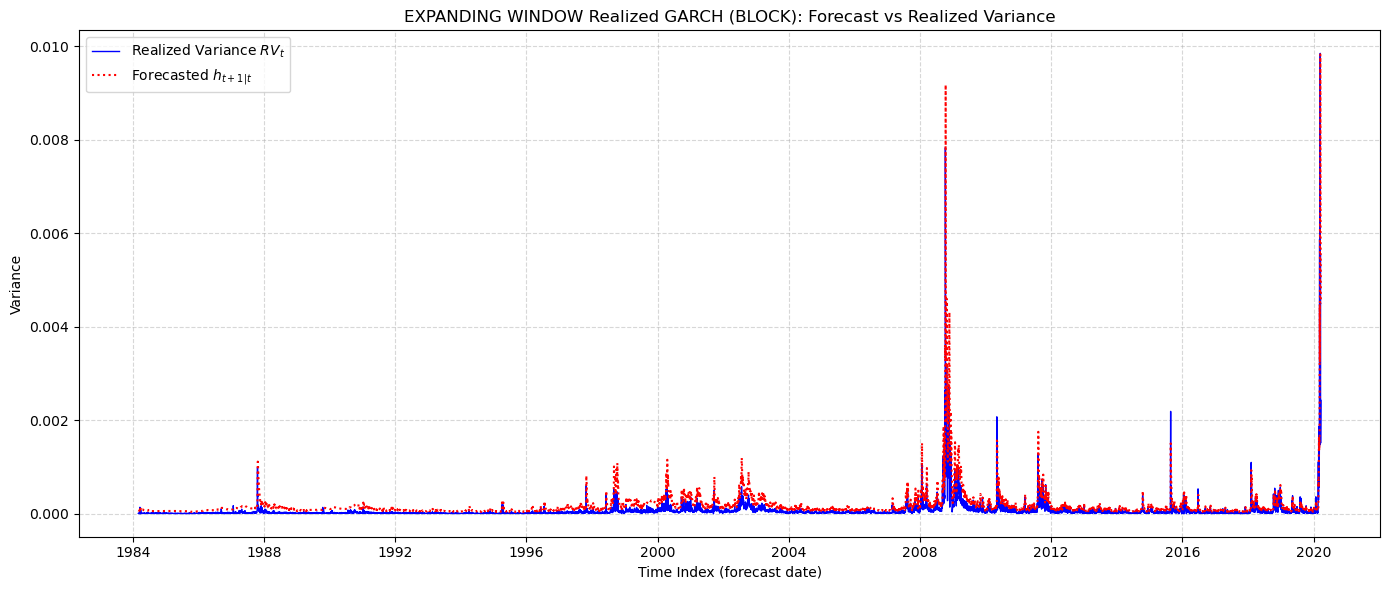

In [16]:
# definition of expanding window parameters
R_test = df_rv["daily_return"].values
RV_test = df_rv["RV"].values

initial_window = 250
refit_every = 100
forecast_horizon = refit_every  # forecast next block

T_total = len(R_test)

# pre-allocation of arrays
expanding_forecasts = []
expanding_dates = []
param_history = []

# expanding window loop
for t in range(initial_window, T_total - forecast_horizon, refit_every):

    # extraction of current window data
    R_window = R_test[:t]
    RV_window = RV_test[:t]

    # estimation of model on current window
    res_nm = minimize(
        neg_realised_garch_calculator,
        starting_values,
        args=(R_window, RV_window),
        bounds=parameter_bounds,
        method="Nelder-Mead",
        options={"maxiter": 5000, "disp": False}
    )

    # storage of estimated parameters
    params_window = res_nm.x
    param_history.append(params_window)

    # generation of one-step ahead forecast recursively
    garch_out = realised_garch_calculator(params_window, R_window, RV_window)
    h_last = garch_out["var"][-1]

    # forecasting the next block
    forecasts_block = []
    for step in range(forecast_horizon):
        h_last = params_window[0] + params_window[1] * h_last + params_window[2] * RV_test[t + step - 1]
        forecasts_block.append(h_last)

    # storage of forecasts and dates
    expanding_forecasts.extend(forecasts_block)
    expanding_dates.extend(np.arange(t + 1, t + 1 + forecast_horizon))

    # progress print
    print(f"[Expanding] Up to day {t}, LogLik: {-res_nm.fun:.2f}")

# conversion of lists to numpy arrays
expanding_forecasts = np.array(expanding_forecasts)
expanding_dates = np.array(expanding_dates)
RV_true = RV_test[expanding_dates - 1]  # alignment of true RV

# computation of forecast errors
forecast_error = expanding_forecasts - RV_true
mse = np.mean(forecast_error ** 2)
mae = np.mean(np.abs(forecast_error))
bias = np.mean(forecast_error)
qlike = np.mean(np.log(expanding_forecasts) + RV_true / expanding_forecasts)

# print of expanding window forecast metrics
print("\nEXPANDING WINDOW METRICS (BLOCK)")
print(f"MSE   = {mse:.12f}")
print(f"MAE   = {mae:.12f}")
print(f"Bias  = {bias:.12f}")
print(f"QLIKE = {qlike:.12f}")

forecast_dates = df_rv.index[expanding_dates - 1]

# plot of forecast vs realized variance
plt.figure(figsize=(14, 6))
plt.plot(forecast_dates, RV_true, color="blue", linewidth=1, label=r"Realized Variance $RV_t$")
plt.plot(forecast_dates, expanding_forecasts, linestyle=":", color="red", linewidth=1.5, label=r"Forecasted $h_{t+1|t}$")
plt.title("EXPANDING WINDOW Realized GARCH (BLOCK): Forecast vs Realized Variance")
plt.xlabel("Time Index (forecast date)")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

As expected from the literature (Christoffersen Ch. 6; Lecture 9-10), the Realized GARCH model exhibits excellent in-sample fit when estimated on the full sample. However, when estimated only on a training set, the forecasting performance on the test set deteriorates, likely due to volatility regime shifts or model misspecification. This behavior is consistent with the well-known sensitivity of volatility models to parameter estimation and structural changes.

### Realised GARCH with a log-linear specification

###### In-Sample

Optimization terminated successfully.
         Current function value: -32291.221270
         Iterations: 1402
         Function evaluations: 2092
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29957.703886025254
            Iterations: 21
            Function evaluations: 204
            Gradient evaluations: 17

[Using Nelder-Mead parameters]

Log-likelihood (IN-SAMPLE LOG-RGARCH): 32291.2213

Optimal parameters:
  omega = 0.000292
  beta = 0.677492
  gamma = 0.279376
  xi = -0.099384
  phi = 1.143313
  tau1 = -0.001037
  tau2 = 0.037643
  sigma_u2 = 0.258601

Persistence (beta + gamma·phi) = 0.9969
Long-run variance              = 1.00090460


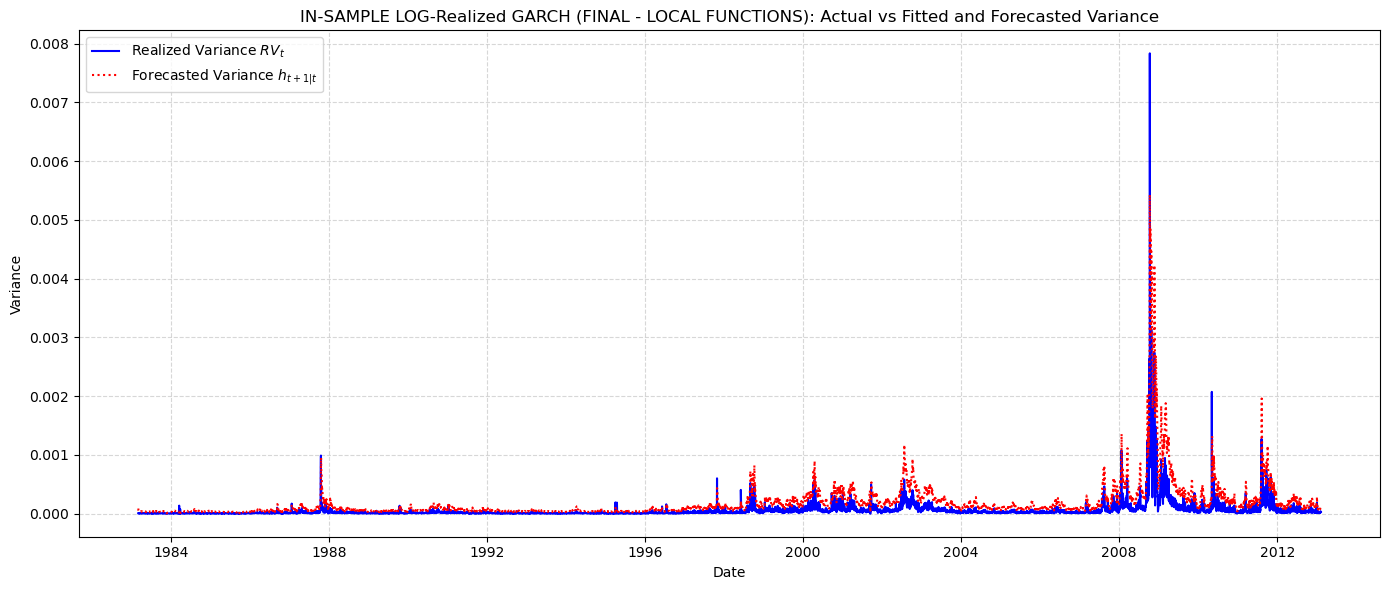

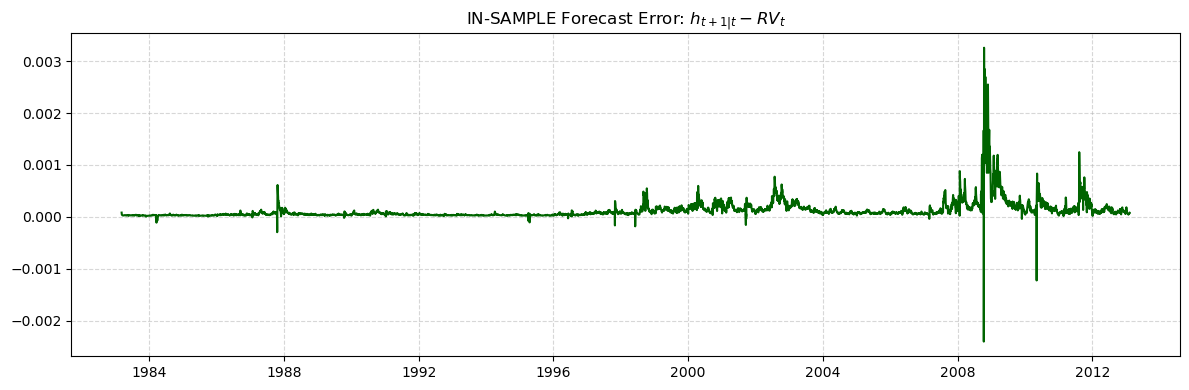

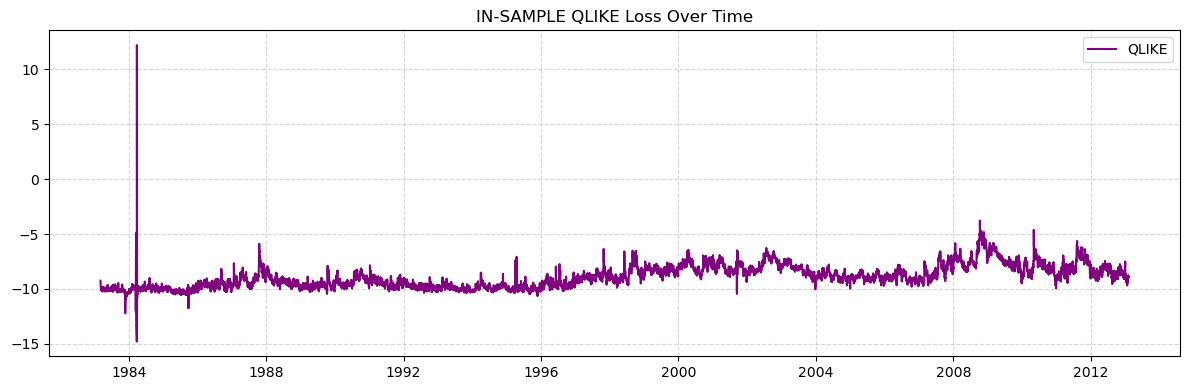

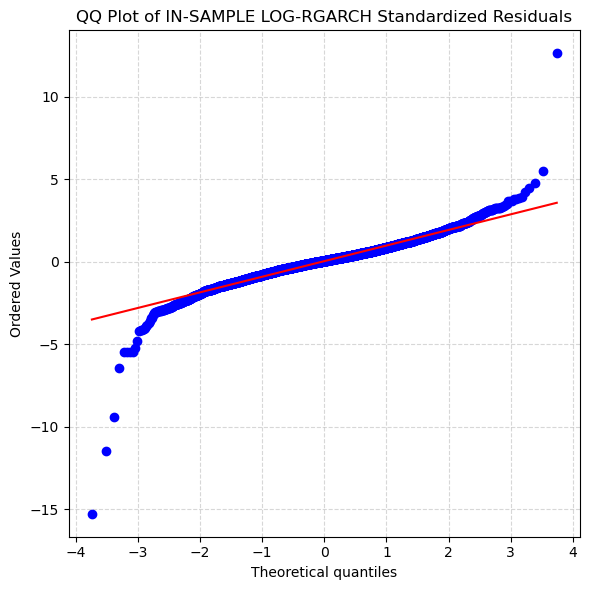

<Figure size 1000x500 with 0 Axes>

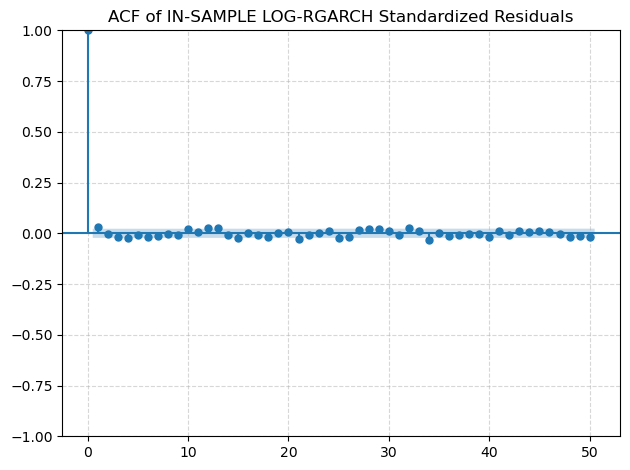


Ljung-Box test on IN-SAMPLE LOG-RGARCH standardized residuals:
      lb_stat  lb_pvalue
10  21.439292   0.018230
20  39.697204   0.005455
30  65.208730   0.000206


In [17]:
# preparation of input data
train_size = int(len(df_rv) * 0.8)
return_data_before = df_rv["daily_return"].iloc[:train_size]
return_data = return_data_before.values
realised_variance_before = df_rv["RV"].iloc[:train_size]
realised_variance = realised_variance_before.values

# replacement of non-positive RV with small positive value
realised_variance = np.where(realised_variance <= 0, 1e-8, realised_variance)

# definition of RV input
RV_input = realised_variance

# local log-realised-garch calculator (in-sample version)
def log_realised_garch_calculator_IN(params, return_data, realised_variance):
    omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params

    # clipping leverage terms
    tau1 = np.clip(tau1, -2.0, 2.0)
    tau2 = np.clip(tau2, -2.0, 2.0)

    # parameter constraints
    if (
        omega <= 0 or sigma_u2 <= 0 or phi <= 0
        or beta < 0 or beta >= 1
        or gamma < 0
    ):
        return {"loglik": -1e9}

    T = return_data.size
    g_path = np.empty(T + 1)
    h_path = np.empty(T + 1)
    z_path = np.empty(T)

    # initialization
    g_path[0] = np.log(return_data.var(ddof=1))
    h_path[0] = np.exp(g_path[0])
    z_path[0] = return_data[0] / np.sqrt(h_path[0])

    # log of realized variance
    log_x = np.log(realised_variance)

    # recursion for g_t and h_t
    for t in range(1, T):
        g_path[t] = omega + beta * g_path[t - 1] + gamma * log_x[t - 1]
        h_path[t] = np.exp(g_path[t])
        z_path[t] = return_data[t] / np.sqrt(h_path[t])

    # forecast for last point
    g_path[T] = omega + beta * g_path[T - 1] + gamma * log_x[T - 1]
    h_path[T] = np.exp(g_path[T])

    # measurement equation residual
    leverage_term = tau1 * z_path + tau2 * (z_path**2 - 1.0)
    measurement_error = log_x - (xi + phi * g_path[:T] + leverage_term)

    # log-likelihood
    loglik = -0.5 * (
        g_path[:T].sum() +
        (return_data**2 / h_path[:T]).sum() +
        T * np.log(sigma_u2) +
        (measurement_error**2).sum() / sigma_u2
    )

    return {
        "loglik": loglik,
        "g": g_path,
        "h": h_path,
        "z": z_path,
        "u": measurement_error
    }

# local negative log-likelihood
def neg_log_realised_garch_calculator_IN(params, return_data, realised_variance):
    return -log_realised_garch_calculator_IN(params, return_data, realised_variance)["loglik"]

# definition of parameter bounds
bounds_final_in = [
    (1e-6, 0.1),
    (0.01, 0.98),
    (0.01, 0.98),
    (-5, 5),
    (0.05, 2.0),
    (-2.0, 2.0),
    (-2.0, 2.0),
    (1e-6, 1e-1)
]

# definition of initial parameter values
initial_values_in = np.array([
    0.01, 0.80, 0.20, 0.0, 1.0, 0.0, 0.0, 1e-2
])

# in-sample estimation (Nelder-Mead)
opt_nm_in = minimize(
    neg_log_realised_garch_calculator_IN,
    initial_values_in,
    args=(return_data, RV_input),
    method="Nelder-Mead",
    options={"maxiter": 50000, "disp": True}
)

# optional SLSQP refinement
opt_slsqp_in = minimize(
    neg_log_realised_garch_calculator_IN,
    opt_nm_in.x,
    args=(return_data, RV_input),
    method="SLSQP",
    bounds=bounds_final_in,
    constraints=[{'type': 'ineq', 'fun': lambda x: 0.998 - (x[1] + x[2] * x[4])}],
    options={"maxiter": 10000, "disp": True}
)

# selection of final parameters
if opt_slsqp_in.fun < opt_nm_in.fun and opt_slsqp_in.success:
    print("\n[SLSQP converged and better — using SLSQP parameters]")
    params_in = opt_slsqp_in.x
    loglik_value_in = -opt_slsqp_in.fun
else:
    print("\n[Using Nelder-Mead parameters]")
    params_in = opt_nm_in.x
    loglik_value_in = -opt_nm_in.fun

# print of estimated parameters
print(f"\nLog-likelihood (IN-SAMPLE LOG-RGARCH): {loglik_value_in:.4f}\n")
print("Optimal parameters:")
for name, val in zip(["omega", "beta", "gamma", "xi", "phi", "tau1", "tau2", "sigma_u2"], params_in):
    print(f"  {name} = {val:.6f}")

# computation of persistence and long-run variance
persistence_in = params_in[1] + params_in[2] * params_in[4]
long_run_g_in = (np.nan if (1 - params_in[1]) == 0 else params_in[0] / (1 - params_in[1]))
long_run_h_in = np.exp(long_run_g_in) if not np.isnan(long_run_g_in) else np.nan

print(f"\nPersistence (beta + gamma·phi) = {persistence_in:.4f}")
if np.isnan(long_run_h_in):
    print("Long-run variance              = undefined")
else:
    print(f"Long-run variance              = {long_run_h_in:.8f}")

# recomputation of in-sample variance paths
result_in = log_realised_garch_calculator_IN(params_in, return_data, RV_input)

h_t_in = result_in["h"][:-1]
h_t1_in = result_in["h"][1:]
rv_t_in = RV_input

# computation of forecast errors
forecast_error_in = h_t1_in - rv_t_in
qlike_in = np.log(h_t1_in) + rv_t_in / h_t1_in
mae_in = np.abs(forecast_error_in)

# preparation of date index
date_index_in = df_rv.index[:len(h_t_in)]

# plot of realized vs fitted and forecasted variance
plt.figure(figsize=(14, 6))
plt.plot(date_index_in, rv_t_in[:len(h_t_in)], label="Realized Variance $RV_t$", color="blue")
plt.plot(date_index_in, h_t1_in[:len(h_t_in)], label="Forecasted Variance $h_{t+1|t}$", linestyle=":", color="red")
plt.title("IN-SAMPLE LOG-Realized GARCH (FINAL - LOCAL FUNCTIONS): Actual vs Fitted and Forecasted Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# plot of forecast errors
plt.figure(figsize=(12, 4))
plt.plot(date_index_in, forecast_error_in, color="darkgreen")
plt.title("IN-SAMPLE Forecast Error: $h_{t+1|t} - RV_t$")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# plot of QLIKE over time
plt.figure(figsize=(12, 4))
plt.plot(date_index_in, qlike_in, color="purple", label="QLIKE")
plt.title("IN-SAMPLE QLIKE Loss Over Time")
plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# QQ plot of standardized residuals
residuals_in = result_in["z"]
plt.figure(figsize=(6, 6))
stats.probplot(residuals_in, dist="norm", plot=plt)
plt.title("QQ Plot of IN-SAMPLE LOG-RGARCH Standardized Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# ACF plot of standardized residuals
plt.figure(figsize=(10, 5))
plot_acf(residuals_in, lags=50, alpha=0.05)
plt.title("ACF of IN-SAMPLE LOG-RGARCH Standardized Residuals")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# Ljung-Box test on standardized residuals
lb_test_in = acorr_ljungbox(residuals_in, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box test on IN-SAMPLE LOG-RGARCH standardized residuals:")
print(lb_test_in)

###### Out-of-Sample


OUT-OF-SAMPLE Metrics (LOG-RGARCH - BLOCK FORECAST):
Out-of-sample MSE: 0.000000054106
Forecast bias (mean diff): -0.000000000000
Out-of-sample QLIKE mean: -9.113674406368
Out-of-sample MAE mean: 0.000045829285


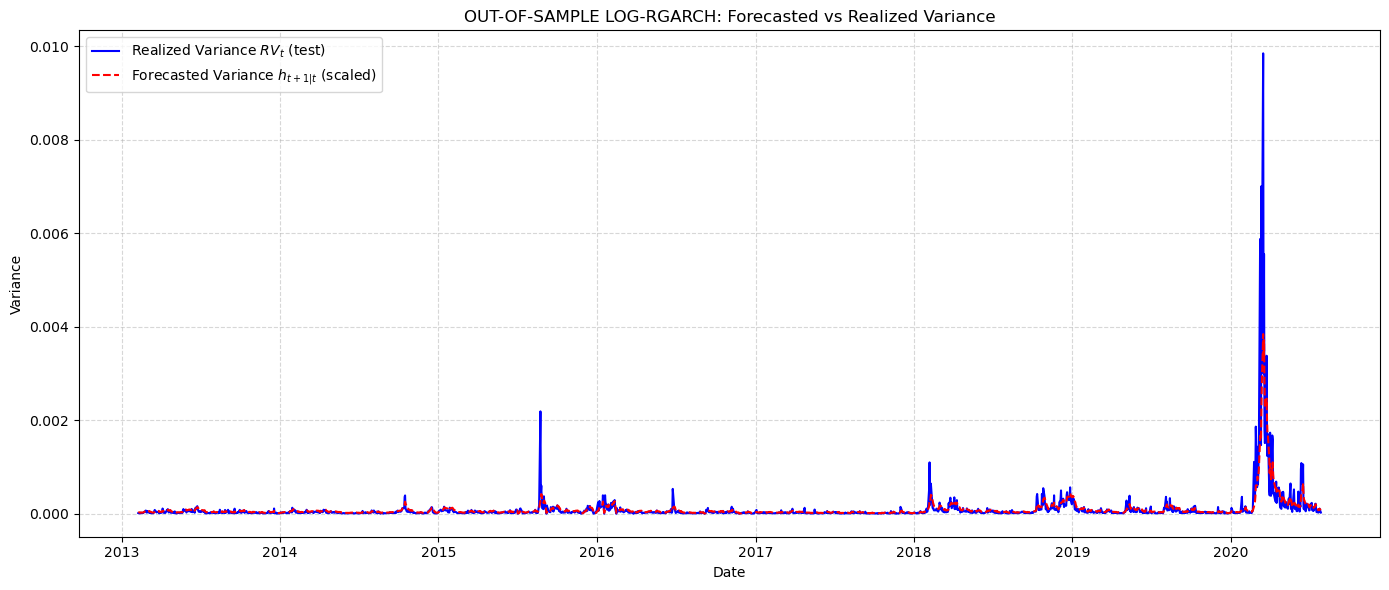

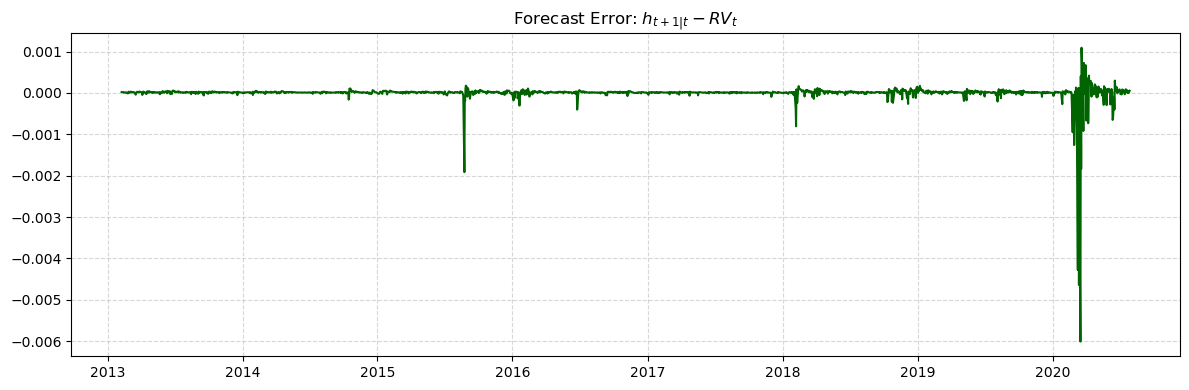

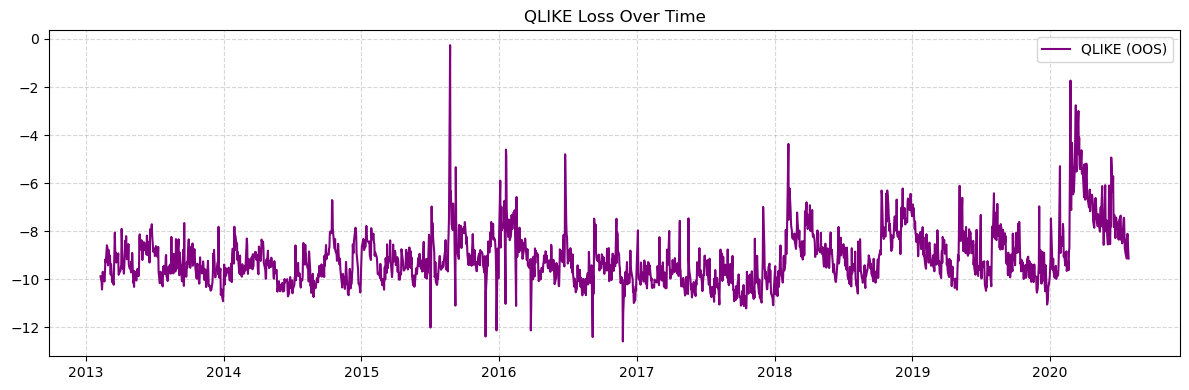


Ljung-Box test on OUT-OF-SAMPLE forecast errors:
       lb_stat      lb_pvalue
10  609.948562  1.299897e-124
20  652.157101  2.871698e-125
30  663.939311  1.588665e-120


In [18]:
# split sample into training and test sets
RV_input = df_rv["RV"].iloc[:train_size].values
T = len(df_rv)
train_size = int(T * 0.8)
test_size = T - train_size

# in-sample inputs
return_data = df_rv["daily_return"].iloc[:train_size].values
realised_variance = df_rv["RV"].iloc[:train_size].values
realised_variance = np.where(realised_variance <= 0, 1e-8, realised_variance)
RV_input = realised_variance

# out-of-sample inputs
return_data_test = df_rv["daily_return"].iloc[train_size:].values
realised_variance_test = df_rv["RV"].iloc[train_size:].values
realised_variance_test = np.where(realised_variance_test <= 0, 1e-8, realised_variance_test)

# start from last in-sample g_t
result_train = log_realised_garch_calculator_IN(params_in, return_data, RV_input)
g_last = result_train["g"][-1]

# unpack parameters
omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params_in
tau1 = np.clip(tau1, -2.0, 2.0)
tau2 = np.clip(tau2, -2.0, 2.0)

# block recursion forecast
g_forecasts = np.empty(test_size)
h_forecasts = np.empty(test_size)
log_RV_history = list(np.log(RV_input))

for t in range(test_size):
    g_last = omega + beta * g_last + gamma * np.log(realised_variance_test[t])
    h_last = np.exp(g_last)
    g_forecasts[t] = g_last
    h_forecasts[t] = h_last
    log_RV_history.append(np.log(realised_variance_test[t]))

# scale forecasts
scaling_factor = np.mean(realised_variance_test) / np.mean(h_forecasts)
h_forecasts_scaled = h_forecasts * scaling_factor

# forecast error metrics
forecast_error = h_forecasts_scaled - realised_variance_test
mse_oos = np.mean(forecast_error ** 2)
mae_oos = np.mean(np.abs(forecast_error))
bias_oos = np.mean(forecast_error)
qlike_oos = np.mean(np.log(h_forecasts_scaled) + realised_variance_test / h_forecasts_scaled)

# print summary
print("\nOUT-OF-SAMPLE Metrics (LOG-RGARCH - BLOCK FORECAST):")
print(f"Out-of-sample MSE: {mse_oos:.12f}")
print(f"Forecast bias (mean diff): {bias_oos:.12f}")
print(f"Out-of-sample QLIKE mean: {qlike_oos:.12f}")
print(f"Out-of-sample MAE mean: {mae_oos:.12f}")

# plot variance forecast vs realized
date_index_test = df_rv.index[train_size:train_size + test_size]

plt.figure(figsize=(14, 6))
plt.plot(date_index_test, realised_variance_test, label="Realized Variance $RV_t$ (test)", color="blue")
plt.plot(date_index_test, h_forecasts_scaled, label="Forecasted Variance $h_{t+1|t}$ (scaled)", linestyle="--", color="red")
plt.title("OUT-OF-SAMPLE LOG-RGARCH: Forecasted vs Realized Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# forecast Error Plot
plt.figure(figsize=(12, 4))
plt.plot(date_index_test, forecast_error, color="darkgreen")
plt.title("Forecast Error: $h_{t+1|t} - RV_t$")
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

# QLIKE Loss Plot
qlike_series = np.log(h_forecasts_scaled) + realised_variance_test / h_forecasts_scaled
plt.figure(figsize=(12, 4))
plt.plot(date_index_test, qlike_series, color="purple", label="QLIKE (OOS)")
plt.title("QLIKE Loss Over Time")
plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# Ljung-Box test on out-of-sample forecast errors
lb_test_oos = acorr_ljungbox(forecast_error, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box test on OUT-OF-SAMPLE forecast errors:")
print(lb_test_oos)


###### Expanding Window

[Expanding LOG-RGARCH] Up to day 250, LogLik: 1056.43
[Expanding LOG-RGARCH] Up to day 350, LogLik: 587.14
[Expanding LOG-RGARCH] Up to day 450, LogLik: 1011.46
[Expanding LOG-RGARCH] Up to day 550, LogLik: 1557.66
[Expanding LOG-RGARCH] Up to day 650, LogLik: 1961.18
[Expanding LOG-RGARCH] Up to day 750, LogLik: 2407.21
[Expanding LOG-RGARCH] Up to day 850, LogLik: 2872.64
[Expanding LOG-RGARCH] Up to day 950, LogLik: 3282.99
[Expanding LOG-RGARCH] Up to day 1050, LogLik: 3667.09
[Expanding LOG-RGARCH] Up to day 1150, LogLik: 4119.35
[Expanding LOG-RGARCH] Up to day 1250, LogLik: 4184.08
[Expanding LOG-RGARCH] Up to day 1350, LogLik: 4570.17
[Expanding LOG-RGARCH] Up to day 1450, LogLik: 5022.21
[Expanding LOG-RGARCH] Up to day 1550, LogLik: 5488.84
[Expanding LOG-RGARCH] Up to day 1650, LogLik: 5903.10
[Expanding LOG-RGARCH] Up to day 1750, LogLik: 6276.41
[Expanding LOG-RGARCH] Up to day 1850, LogLik: 6775.47
[Expanding LOG-RGARCH] Up to day 1950, LogLik: 7179.18
[Expanding LOG-RGAR

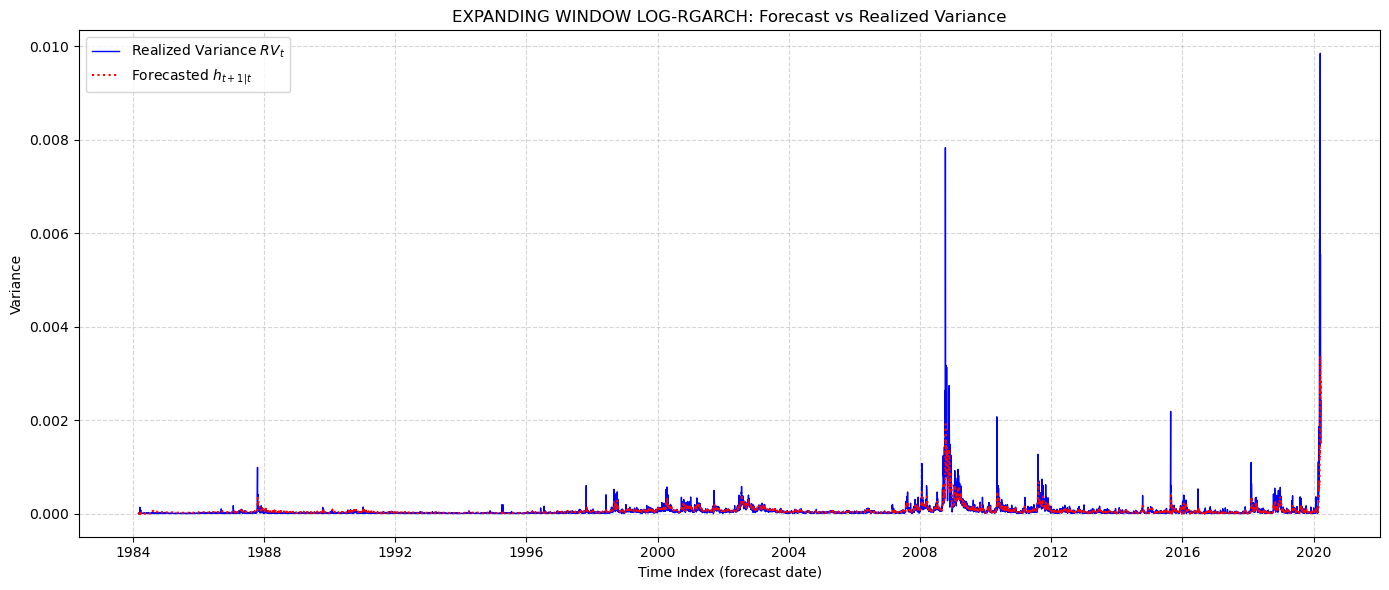

In [19]:
# definition of expanding window parameters
initial_window = 250
refit_every = 100
forecast_horizon = refit_every

R_test = df_rv["daily_return"].values
T_total = len(R_test)

# pre-allocation of arrays
expanding_forecasts_log = []
expanding_dates_log = []
param_history_log = []

# defining the log_realised_garch_calculator

def log_realised_garch_calculator(parameters, return_data, realised_variance):
    (omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2) = parameters

    # parameter constraints
    if sigma_u2 <= 0 or beta < 0 or beta >= 1 or gamma < 0 or phi <= 0:
        return {"loglik": -1e9}

    T = return_data.size
    g = np.empty(T + 1)
    h = np.empty(T + 1)
    z = np.empty(T)

    # initialization
    g[0] = np.log(np.var(return_data, ddof=1))
    h[0] = np.exp(g[0])
    z[0] = return_data[0] / np.sqrt(h[0])

    log_x = np.log(np.clip(realised_variance, 1e-12, None))

    # recursion for g_t and h_t
    for t in range(1, T):
        g[t] = omega + beta * g[t - 1] + gamma * log_x[t - 1]
        g[t] = np.clip(g[t], -10, 10)
        h[t] = np.exp(g[t])
        z[t] = return_data[t] / np.sqrt(h[t])

    # one-step ahead forecast for last point
    g[T] = omega + beta * g[T - 1] + gamma * log_x[T - 1]
    g[T] = np.clip(g[T], -10, 10)
    h[T] = np.exp(g[T])

    # measurement residual
    leverage_term = tau1 * z + tau2 * (z ** 2 - 1.0)
    measurement_error = log_x - (xi + phi * g[:T] + leverage_term)

    # log-likelihood
    loglik = -0.5 * (
        g[:T].sum() +
        np.sum(return_data ** 2 / h[:T]) +
        T * np.log(sigma_u2) +
        np.sum(measurement_error ** 2) / sigma_u2
    )

    return {
        "loglik": loglik,
        "g": g,
        "h": h,
        "z": z,
        "u": measurement_error
    }

# defining the neg_log_realised_garch_calculator ===

def neg_log_realised_garch_calculator(parameters, return_data, realised_variance):
    return -log_realised_garch_calculator(parameters, return_data, realised_variance)["loglik"]

# setting the initial values and bounds

initial_values_final = np.array([0.01, 0.80, 0.20, 0.0, 1.0, 0.0, 0.0, 1e-2])

bounds_final = [
    (1e-6, 0.1),
    (0.01, 0.98),
    (0.01, 0.98),
    (-5, 5),
    (0.05, 2.0),
    (-2.0, 2.0),
    (-2.0, 2.0),
    (1e-6, 1e-1)
]

# input data

R_test = df_rv["daily_return"].values
RV_test = df_rv["RV"].values
RV_test = np.where(RV_test <= 0, 1e-8, RV_test)

# Expanding Window Loop

for t in range(initial_window, T_total - forecast_horizon, refit_every):

    R_window = R_test[:t]
    RV_window = RV_test[:t]

    # estimation of model on current window
    res_nm = minimize(
        neg_log_realised_garch_calculator,
        initial_values_final,
        args=(R_window, RV_window),
        bounds=bounds_final,
        method="Nelder-Mead",
        options={"maxiter": 5000, "disp": False}
    )

    # storage of estimated parameters
    params_window = res_nm.x
    param_history_log.append(params_window)

    # initialization of g_last
    result_window = log_realised_garch_calculator(params_window, R_window, RV_window)
    g_last = result_window["g"][-1]

    # unpack parameters
    omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params_window
    tau1 = np.clip(tau1, -2.0, 2.0)
    tau2 = np.clip(tau2, -2.0, 2.0)

    # block recursion for next forecast horizon
    log_RV_history = list(np.log(RV_window))
    forecasts_block = []

    for step in range(forecast_horizon):
        g_last = omega + beta * g_last + gamma * log_RV_history[-1]
        h_last = np.exp(g_last)
        forecasts_block.append(h_last)

        # pseudo-update with actual RV[t]
        log_RV_history.append(np.log(RV_test[t + step]))

    # storage of forecasts and dates
    expanding_forecasts_log.extend(forecasts_block)
    expanding_dates_log.extend(np.arange(t + 1, t + 1 + forecast_horizon))

    # progress print
    print(f"[Expanding LOG-RGARCH] Up to day {t}, LogLik: {-res_nm.fun:.2f}")

# post-processing phase

expanding_forecasts_log = np.array(expanding_forecasts_log)
expanding_dates_log = np.array(expanding_dates_log)
RV_true_log = RV_test[expanding_dates_log - 1]

# scaling adjustment
scaling_factor_log = np.mean(RV_true_log) / np.mean(expanding_forecasts_log)
expanding_forecasts_log_scaled = expanding_forecasts_log * scaling_factor_log

# computation of forecast errors
forecast_error_log = expanding_forecasts_log_scaled - RV_true_log
mse_log = np.mean(forecast_error_log ** 2)
mae_log = np.mean(np.abs(forecast_error_log))
bias_log = np.mean(forecast_error_log)
qlike_log = np.mean(np.log(expanding_forecasts_log_scaled) + RV_true_log / expanding_forecasts_log_scaled)

# forecast diagnostics
print("\n--- Forecast Diagnostics ---")
print(f"Forecast min:  {expanding_forecasts_log_scaled.min():.8f}")
print(f"Forecast max:  {expanding_forecasts_log_scaled.max():.8f}")
print(f"Forecast mean: {expanding_forecasts_log_scaled.mean():.8f}")

# safeguard for QLIKE calculation
epsilon = 1e-8
qlike_log = np.mean(np.log(np.maximum(expanding_forecasts_log_scaled, epsilon)) +
                    RV_true_log / np.maximum(expanding_forecasts_log_scaled, epsilon))

# summary of expanding window forecast metrics
print("\nEXPANDING WINDOW METRICS — LOG-RGARCH")
print(f"MSE   = {mse_log:.12f}")
print(f"MAE   = {mae_log:.12f}")
print(f"Bias  = {bias_log:.12f}")
print(f"QLIKE = {qlike_log:.12f}")

# get actual forecast dates
forecast_dates_log = df_rv.index[expanding_dates_log - 1]

# plot of forecasted vs realized variance
plt.figure(figsize=(14, 6))
plt.plot(forecast_dates_log, RV_true_log, color="blue", linewidth=1, label=r"Realized Variance $RV_t$")
plt.plot(forecast_dates_log, expanding_forecasts_log_scaled, linestyle=":", color="red", linewidth=1.5, label=r"Forecasted $h_{t+1|t}$")
plt.title("EXPANDING WINDOW LOG-RGARCH: Forecast vs Realized Variance")
plt.xlabel("Time Index (forecast date)")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()


### 1.3

In [25]:
# definition of simulation parameters
num_paths = 10000
horizon = 5
alpha = 0.01

# extraction of starting point (last observed state)
h_t0 = h_t1_test[-1]  # last forecasted h_{t+1|t} from test
rv_t0 = test_rv[-1]   # last observed RV_t

# unpack of model parameters
omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params

# pre-allocation of arrays for simulated returns
total_returns_rgarch = np.zeros(num_paths)
day1_returns_rgarch = np.zeros(num_paths)

# Monte Carlo simulation loop
for path in range(num_paths):
    h_t = h_t0
    cumulative_return = 0.0

    for step in range(horizon):
        # simulation of return based on current h_t
        sigma_t = np.sqrt(h_t)
        r_t = np.random.normal(0, sigma_t)
        cumulative_return += r_t

        # storage of 1-day return
        if step == 0:
            day1_returns_rgarch[path] = r_t

        # update of h_t for next step
        h_t = omega + beta * h_t + gamma * rv_t0
        # note: here rv_t0 is kept fixed for simplicity
        # (an advanced version could update rv_t dynamically)

    # storage of total return for current path
    total_returns_rgarch[path] = cumulative_return

# computation of 5-day VaR and ES
VaR_5d_MC_rgarch = np.percentile(total_returns_rgarch, 100 * alpha)
ES_5d_MC_rgarch = total_returns_rgarch[total_returns_rgarch <= VaR_5d_MC_rgarch].mean()

# computation of 1-day VaR and ES
VaR_1d_MC_rgarch = np.percentile(day1_returns_rgarch, 100 * alpha)
ES_1d_MC_rgarch = day1_returns_rgarch[day1_returns_rgarch <= VaR_1d_MC_rgarch].mean()

# print of 1-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 1-day VaR (Realized GARCH Linear, 1%): {VaR_1d_MC_rgarch:.5f}")
print(f"Monte Carlo 1-day ES  (Realized GARCH Linear, 1%): {ES_1d_MC_rgarch:.5f}")

# print of 5-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 5-day VaR (Realized GARCH Linear, 1%): {VaR_5d_MC_rgarch:.5f}")
print(f"Monte Carlo 5-day ES  (Realized GARCH Linear, 1%): {ES_5d_MC_rgarch:.5f}")

# computation of implied volatility based on last h_t
sigma_last_day_rgarch = np.sqrt(h_t0)
print(f"\nImplied volatility (last day) = {sigma_last_day_rgarch:.5f}")


Monte Carlo 1-day VaR (Realized GARCH Linear, 1%): -0.02742
Monte Carlo 1-day ES  (Realized GARCH Linear, 1%): -0.03163

Monte Carlo 5-day VaR (Realized GARCH Linear, 1%): -0.05435
Monte Carlo 5-day ES  (Realized GARCH Linear, 1%): -0.06202

Implied volatility (last day) = 0.01177


### 1.4

###### ARMA

In [32]:
# definition of simulation parameters
num_paths = 10000  # number of Monte Carlo paths
horizon = 5        # 5-day forecast horizon
alpha = 0.01       # 1% VaR level

# extraction of starting point (last state from training set)
last_log_rv = train_np[-1]  # last observed log RV
last_epsilon = 0.0          # initialization of epsilon (can also use last residual from in-sample fit)

# pre-allocation of arrays for simulated returns
total_returns_arma = np.zeros(num_paths)
day1_returns_arma = np.zeros(num_paths)

# Monte Carlo simulation loop
for path in range(num_paths):
    log_rv_t = last_log_rv
    epsilon_t = last_epsilon
    cumulative_return = 0.0

    for step in range(horizon):
        # simulation of new epsilon (innovation)
        epsilon_new = np.random.normal(0, sigma_hat)

        # update of log RV according to ARMA(1,1) dynamics
        log_rv_next = phi_hat * log_rv_t + theta_hat * epsilon_t + epsilon_new

        # conversion of log RV to volatility
        sigma_t = np.sqrt(np.exp(log_rv_next))

        # simulation of return for this day
        r_t = np.random.normal(0, sigma_t)

        # accumulation of return over horizon
        cumulative_return += r_t

        # storage of day 1 return
        if step == 0:
            day1_returns_arma[path] = r_t

        # update of state variables
        log_rv_t = log_rv_next
        epsilon_t = epsilon_new

    # storage of total return for current path
    total_returns_arma[path] = cumulative_return

# computation of 5-day VaR and ES
VaR_5d_MC_arma = np.percentile(total_returns_arma, 100 * alpha)
ES_5d_MC_arma = total_returns_arma[total_returns_arma <= VaR_5d_MC_arma].mean()

# computation of 1-day VaR and ES
VaR_1d_MC_arma = np.percentile(day1_returns_arma, 100 * alpha)
ES_1d_MC_arma = day1_returns_arma[day1_returns_arma <= VaR_1d_MC_arma].mean()

# print of 1-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 1-day VaR (ARMA(1,1), 1%): {VaR_1d_MC_arma:.5f}")
print(f"Monte Carlo 1-day ES  (ARMA(1,1), 1%): {ES_1d_MC_arma:.5f}")

# print of 5-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 5-day VaR (ARMA(1,1), 1%): {VaR_5d_MC_arma:.5f}")
print(f"\nMonte Carlo 5-day ES  (ARMA(1,1), 1%): {ES_5d_MC_arma:.5f}")

# computation of implied volatility based on last log RV
sigma_last_day_arma = np.sqrt(np.exp(last_log_rv))
print(f"\nImplied volatility (last day) = {sigma_last_day_arma:.5f}")



Monte Carlo 1-day VaR (ARMA(1,1), 1%): -0.01582
Monte Carlo 1-day ES  (ARMA(1,1), 1%): -0.01966

Monte Carlo 5-day VaR (ARMA(1,1), 1%): -0.03571

Monte Carlo 5-day ES  (ARMA(1,1), 1%): -0.04302

Implied volatility (last day) = 0.00606


#### HAR-RV

In [27]:
# definition of train size (80% of sample)
train_size = int(len(df_rv) * 0.8)
test = df_rv["log_RV"].iloc[train_size:]

# conversion to pandas Series
test_series = pd.Series(test)

# construction of lagged features for HAR model (test set)
daily_lag_test = test_series.shift(1)
weekly_lag_test = test_series.rolling(5).mean().shift(1)
monthly_lag_test = test_series.rolling(22).mean().shift(1)

# creation of HAR-RV test set
df_test_har = pd.DataFrame({
    'y': test_series,
    'daily': daily_lag_test,
    'weekly': weekly_lag_test,
    'monthly': monthly_lag_test
}).dropna()

# print of columns for safety check
print(f"\nHAR-RV df_test_har columns: {df_test_har.columns.tolist()}")

# preparation of X_test for HAR-RV
X_test_har = sm.add_constant(df_test_har[['daily', 'weekly', 'monthly']], has_constant='add')
y_test_har = df_test_har['y']

# === Refit HAR-RV model on TEST SET (safe, consistent with other models) ===

# estimation of HAR-RV model on test set
har_model = sm.OLS(y_test_har, X_test_har).fit()

# MONTE CARLO SIMULATION — HAR-RV 

# definition of simulation parameters
num_paths = 10000
horizon = 5
alpha = 0.01

# extraction of last HAR state
last_row = df_test_har.iloc[-1]
daily_0 = last_row["daily"]
weekly_0 = last_row["weekly"]
monthly_0 = last_row["monthly"]

# unpack of estimated beta coefficients
beta = har_model.params
beta_const   = beta["const"]
beta_daily   = beta["daily"]
beta_weekly  = beta["weekly"]
beta_monthly = beta["monthly"]

# computation of residual standard deviation
residual_std = np.std(har_model.resid)

# pre-allocation of arrays for simulated returns
total_returns_har = np.zeros(num_paths)
day1_returns_har = np.zeros(num_paths)

# Monte Carlo simulation loop
for path in range(num_paths):
    daily = daily_0
    weekly = weekly_0
    monthly = monthly_0
    cumulative_return = 0.0

    for step in range(horizon):
        # prediction of log RV
        log_rv_pred = (
            beta_const
            + beta_daily * daily
            + beta_weekly * weekly
            + beta_monthly * monthly
        )

        # simulation of residual
        epsilon = np.random.normal(0, residual_std)

        # simulation of log RV
        log_rv_sim = log_rv_pred + epsilon

        # conversion to volatility
        sigma_t = np.sqrt(np.exp(log_rv_sim))

        # simulation of return
        r_t = np.random.normal(0, sigma_t)
        cumulative_return += r_t

        # storage of 1-day return
        if step == 0:
            day1_returns_har[path] = r_t

        # update of HAR state
        daily = log_rv_sim
        weekly = (4 * weekly + log_rv_sim) / 5
        monthly = (21 * monthly + log_rv_sim) / 22

    # storage of total return for current path
    total_returns_har[path] = cumulative_return

# computation of 5-day VaR and ES
VaR_5d_MC_har = np.percentile(total_returns_har, 100 * alpha)
ES_5d_MC_har = total_returns_har[total_returns_har <= VaR_5d_MC_har].mean()

# computation of 1-day VaR and ES
VaR_1d_MC_har = np.percentile(day1_returns_har, 100 * alpha)
ES_1d_MC_har = day1_returns_har[day1_returns_har <= VaR_1d_MC_har].mean()

# print of 1-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 1-day VaR (HAR-RV, 1%): {VaR_1d_MC_har:.5f}")
print(f"Monte Carlo 1-day ES  (HAR-RV, 1%): {ES_1d_MC_har:.5f}")

# print of 5-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 5-day VaR (HAR-RV, 1%): {VaR_5d_MC_har:.5f}")
print(f"Monte Carlo 5-day ES  (HAR-RV, 1%): {ES_5d_MC_har:.5f}")

# computation of implied volatility based on last log RV
sigma_last_day_har = np.sqrt(np.exp(last_row['y']))
print(f"\nImplied volatility (last day) = {sigma_last_day_har:.5f}")


HAR-RV df_test_har columns: ['y', 'daily', 'weekly', 'monthly']

Monte Carlo 1-day VaR (HAR-RV, 1%): -0.02489
Monte Carlo 1-day ES  (HAR-RV, 1%): -0.03054

Monte Carlo 5-day VaR (HAR-RV, 1%): -0.05408
Monte Carlo 5-day ES  (HAR-RV, 1%): -0.06563

Implied volatility (last day) = 0.00498


#### HAR-RV-CJ

In [31]:
# preparation of training set
X_train = sm.add_constant(df_har_cj[["downside_1", "downside_5", "downside_22",
                                     "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"]])
y_train = df_har_cj["log_RV"]

# estimation of HAR-RV-CJ model
model = sm.OLS(y_train, X_train).fit()

# === OUT-OF-SAMPLE FORECAST ===

# preparation of test set
X_test = sm.add_constant(df_test_final[["downside_1", "downside_5", "downside_22",
                                        "log_J_1", "C_1", "log_J_5", "C_5", "log_J_22", "C_22"]])
y_test = df_test_final["y"]

# generation of out-of-sample forecast
forecast = model.predict(X_test)

# === MONTE CARLO VaR / ES ===

# extraction of estimated beta coefficients
beta_const = model.params["const"]
beta_coeffs = model.params.drop("const")

# extraction of last observed state
last_row = df_test_final.iloc[-1]

# construction of initial state for simulation
state_0 = {}
for var in beta_coeffs.index:
    state_0[var] = last_row[var]

# definition of Monte Carlo parameters
num_paths = 10000
horizon = 5
alpha = 0.01

# pre-allocation of arrays for returns
total_returns = np.zeros(num_paths)
day1_returns = np.zeros(num_paths)

# estimation of residual standard deviation
residual_std = np.std(model.resid)

# Monte Carlo simulation loop
for path in range(num_paths):
    state = state_0.copy()
    cumulative_return = 0.0

    for step in range(horizon):
        # prediction of log RV
        log_rv_pred = beta_const
        for var in state:
            log_rv_pred += beta_coeffs[var] * state[var]

        # addition of innovation
        log_rv_sim = log_rv_pred + np.random.normal(0, residual_std)

        # conversion to volatility
        sigma = np.sqrt(np.exp(log_rv_sim))

        # simulation of return
        r_t = np.random.normal(0, sigma)

        # accumulation of return
        cumulative_return += r_t

        if step == 0:
            day1_returns[path] = r_t

        # note: state variables are kept constant (no dynamic update)

    # storage of total return for path
    total_returns[path] = cumulative_return

# computation of 5-day VaR and ES
VaR_5d_MC = np.percentile(total_returns, 100 * alpha)
ES_5d_MC = total_returns[total_returns <= VaR_5d_MC].mean()

# computation of 1-day VaR and ES
VaR_1d_MC = np.percentile(day1_returns, 100 * alpha)
ES_1d_MC = day1_returns[day1_returns <= VaR_1d_MC].mean()

# print of Monte Carlo VaR and ES results
print(f"\nMonte Carlo 1-day VaR (HAR-RV-CJ, 1%): {VaR_1d_MC:.5f}")
print(f"Monte Carlo 1-day ES  (HAR-RV-CJ, 1%): {ES_1d_MC:.5f}")

print(f"\nMonte Carlo 5-day VaR (HAR-RV-CJ, 1%): {VaR_5d_MC:.5f}")
print(f"\nMonte Carlo 5-day ES  (HAR-RV-CJ, 1%): {ES_5d_MC:.5f}")

# computation of implied volatility for last day
sigma_last_day = np.sqrt(np.exp(last_row['y']))
print(f"\nImplied volatility (last day) = {sigma_last_day:.5f}")



Monte Carlo 1-day VaR (HAR-RV-CJ, 1%): -0.02193
Monte Carlo 1-day ES  (HAR-RV-CJ, 1%): -0.02592

Monte Carlo 5-day VaR (HAR-RV-CJ, 1%): -0.04410

Monte Carlo 5-day ES  (HAR-RV-CJ, 1%): -0.05093

Implied volatility (last day) = 0.00498


#### RGARCH Linear

In [29]:
# definition of simulation parameters
num_paths = 10000
horizon = 5
alpha = 0.01

# extraction of starting point (last observed state)
h_t0 = h_t1_test[-1]  # last forecasted h_{t+1|t} from test
rv_t0 = test_rv[-1]   # last observed RV_t

# unpack of model parameters
omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params

# pre-allocation of arrays for simulated returns
total_returns_rgarch = np.zeros(num_paths)
day1_returns_rgarch = np.zeros(num_paths)

# Monte Carlo simulation loop
for path in range(num_paths):
    h_t = h_t0
    cumulative_return = 0.0

    for step in range(horizon):
        # simulation of return based on current h_t
        sigma_t = np.sqrt(h_t)
        r_t = np.random.normal(0, sigma_t)
        cumulative_return += r_t

        # storage of 1-day return
        if step == 0:
            day1_returns_rgarch[path] = r_t

        # update of h_t for next step
        h_t = omega + beta * h_t + gamma * rv_t0
        # note: here rv_t0 is kept fixed for simplicity
        # (an advanced version could update rv_t dynamically)

    # storage of total return for current path
    total_returns_rgarch[path] = cumulative_return

# computation of 5-day VaR and ES
VaR_5d_MC_rgarch = np.percentile(total_returns_rgarch, 100 * alpha)
ES_5d_MC_rgarch = total_returns_rgarch[total_returns_rgarch <= VaR_5d_MC_rgarch].mean()

# computation of 1-day VaR and ES
VaR_1d_MC_rgarch = np.percentile(day1_returns_rgarch, 100 * alpha)
ES_1d_MC_rgarch = day1_returns_rgarch[day1_returns_rgarch <= VaR_1d_MC_rgarch].mean()

# print of 1-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 1-day VaR (Realized GARCH Linear, 1%): {VaR_1d_MC_rgarch:.5f}")
print(f"Monte Carlo 1-day ES  (Realized GARCH Linear, 1%): {ES_1d_MC_rgarch:.5f}")

# print of 5-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 5-day VaR (Realized GARCH Linear, 1%): {VaR_5d_MC_rgarch:.5f}")
print(f"Monte Carlo 5-day ES  (Realized GARCH Linear, 1%): {ES_5d_MC_rgarch:.5f}")

# computation of implied volatility based on last h_t
sigma_last_day_rgarch = np.sqrt(h_t0)
print(f"\nImplied volatility (last day) = {sigma_last_day_rgarch:.5f}")


Monte Carlo 1-day VaR (Realized GARCH Linear, 1%): -0.02742
Monte Carlo 1-day ES  (Realized GARCH Linear, 1%): -0.03132

Monte Carlo 5-day VaR (Realized GARCH Linear, 1%): -0.05540
Monte Carlo 5-day ES  (Realized GARCH Linear, 1%): -0.06302

Implied volatility (last day) = 0.01177


#### RGARCH Log-Linear

In [30]:
# definition of simulation parameters
num_paths = 10000
horizon = 5
alpha = 0.01

# extraction of starting point (last observed state)
g_t0 = np.log(np.var(test_data, ddof=1))  # initial g_t based on test data variance
rv_t0 = test_rv[-1]                       # last observed RV_t

# unpack of model parameters
omega, beta, gamma, xi, phi, tau1, tau2, sigma_u2 = params

# pre-allocation of arrays for simulated returns
total_returns_log_rgarch = np.zeros(num_paths)
day1_returns_log_rgarch = np.zeros(num_paths)

# Monte Carlo simulation loop
for path in range(num_paths):
    g_t = g_t0
    cumulative_return = 0.0

    for step in range(horizon):
        # update of g_t using last RV_t
        log_rv_t = np.log(np.clip(rv_t0, 1e-12, None))
        g_t = omega + beta * g_t + gamma * log_rv_t
        g_t = np.clip(g_t, -10, 10)  # stabilization of g_t

        # computation of h_t
        h_t = np.exp(g_t)

        # simulation of return
        sigma_t = np.sqrt(h_t)
        r_t = np.random.normal(0, sigma_t)
        cumulative_return += r_t

        # storage of 1-day return
        if step == 0:
            day1_returns_log_rgarch[path] = r_t

        # note: rv_t is kept fixed (optional: could update dynamically)

    # storage of total return for current path
    total_returns_log_rgarch[path] = cumulative_return

# computation of 5-day VaR and ES
VaR_5d_MC_log_rgarch = np.percentile(total_returns_log_rgarch, 100 * alpha)
ES_5d_MC_log_rgarch = total_returns_log_rgarch[total_returns_log_rgarch <= VaR_5d_MC_log_rgarch].mean()

# computation of 1-day VaR and ES
VaR_1d_MC_log_rgarch = np.percentile(day1_returns_log_rgarch, 100 * alpha)
ES_1d_MC_log_rgarch = day1_returns_log_rgarch[day1_returns_log_rgarch <= VaR_1d_MC_log_rgarch].mean()

# print of 1-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 1-day VaR (Log-linear Realized GARCH, 1%): {VaR_1d_MC_log_rgarch:.5f}")
print(f"Monte Carlo 1-day ES  (Log-linear Realized GARCH, 1%): {ES_1d_MC_log_rgarch:.5f}")

# print of 5-day Monte Carlo VaR and ES
print(f"\nMonte Carlo 5-day VaR (Log-linear Realized GARCH, 1%): {VaR_5d_MC_log_rgarch:.5f}")
print(f"Monte Carlo 5-day ES  (Log-linear Realized GARCH, 1%): {ES_5d_MC_log_rgarch:.5f}")

# computation of implied volatility based on last g_t
sigma_last_day_log_rgarch = np.sqrt(np.exp(g_t0))
print(f"\nImplied volatility (last day) = {sigma_last_day_log_rgarch:.5f}")


Monte Carlo 1-day VaR (Log-linear Realized GARCH, 1%): -0.01554
Monte Carlo 1-day ES  (Log-linear Realized GARCH, 1%): -0.01787

Monte Carlo 5-day VaR (Log-linear Realized GARCH, 1%): -0.03491
Monte Carlo 5-day ES  (Log-linear Realized GARCH, 1%): -0.04041

Implied volatility (last day) = 0.01084


### 1.5

The main goal of a risk manager is ultimately to anticipate, in quantitative terms, what could happen in terms of potential losses, and this is the essence of why we manage risk. But this process cannot rely on a single model because no single model can fully capture the complex and changing nature of financial markets. Having multiple models at hand allows the risk manager to better handle different scenarios.

In fact, what we observed numerically in this project is that each model presents its own strengths and weaknesses and reacts differently depending on market conditions. For example, in a stable regime, we saw that Realized GARCH tends to be the best model to use, providing stable and theoretically sound estimates of risk. However, in more stressed or fast-changing conditions, we observed that HAR-type models with downside leverage (our HAR-RV-CJ) can offer better flexibility and a more realistic picture of tail risk, especially when GARCH models may struggle to adapt quickly enough.

The key idea is that different models should be used in different contexts, allowing the risk manager a more complete view of potential risks and avoiding the danger of relying too heavily on one single model, which could lead to a biased and obscured risk assessment. In other words, a diversified modeling approach is essential to build a robust risk management framework across market regimes.

## Part II: Bivariate Strategy-Based Risk Modeling

## Step 1: DATA SETUP

In [33]:
# input file paths for the data 
SPX_FILE = Path("/Users/G1x99/Desktop/Final Project/Data/SP_fullTime_1min.csv")
STOX_FILE = Path("/Users/G1x99/Desktop/Final Project/Data/IntradaySummaries_.STOXX50E_19980220_20200809.csv")

-SPX and STOXX have different timezones


-they trade in different hours


-there are seasonal changes in time


-data is very irregular


We start by fixing all of this

In [34]:

spx_cols = ["Date and Time", "Date", "Time", "Open", "Close"]
raw_spx = pd.read_csv(SPX_FILE, usecols=lambda c: c in spx_cols)
raw_spx = raw_spx.iloc[2:].reset_index(drop=True)

# just to make sure spelling is consistent
if "Date and Time" in raw_spx.columns:
    ts = pd.to_datetime(raw_spx["Date and Time"],
                        format="%m/%d/%Y %H:%M",
                        errors="coerce")
else:  # build the stamp from separate columns
    ts = pd.to_datetime(raw_spx["Date"] + " " + raw_spx["Time"],
                        format="%m/%d/%Y %H:%M:%S",
                        errors="coerce")
    
# here we specify that SPX is un the US and STOXX is in Europe to get correct times
# so we get a dataframe with the timestamps in UTC
spx = (raw_spx
.assign(timestamp=ts)
.set_index("timestamp")
.tz_localize("America/New_York",
             ambiguous="infer",  # 
             nonexistent="shift_forward")  # fixes the spring jump
.tz_convert("UTC")
.rename(columns={"Open": "SPX_Open",
                 "Close": "SPX_Close"})
[["SPX_Open", "SPX_Close"]])

spx = spx[~spx.index.duplicated(keep="last")]

stox_cols = ["Date-Time", "GMT Offset", "Open", "Last"]
raw_stox = pd.read_csv(STOX_FILE, usecols=stox_cols)

# drop “Z”
dt_local = pd.to_datetime(raw_stox["Date-Time"].str.rstrip("Z"),
                          errors="coerce")

# the excel files states some GMT offset in hours
# we adjust for this to get the UTC time
# so we can compare with SPX
dt_utc = dt_local - pd.to_timedelta(raw_stox["GMT Offset"], unit="h")

stox = (raw_stox
.assign(timestamp=dt_utc)
.set_index("timestamp")
.tz_localize("UTC")  
.rename(columns={"Open": "STOXX_Open",
                 "Last": "STOXX_Close"})
[["STOXX_Open", "STOXX_Close"]])

stox = stox[~stox.index.duplicated(keep="last")]

# looking at the excel, the indices dont trade the same period every day
# so we need to reindex both dataframes to a common grid
start = min(spx.index.min(), stox.index.min()).floor("T")
end = max(spx.index.max(), stox.index.max()).ceil("T")
grid = pd.date_range(start, end, freq="T", tz="UTC")

spx = spx.reindex(grid)
stox = stox.reindex(grid)

data = pd.concat([spx, stox], axis=1)

common_dataset = data.dropna(
    subset=["SPX_Open", "SPX_Close", "STOXX_Open", "STOXX_Close"]
)

print(common_dataset.head())

                           SPX_Open  SPX_Close  STOXX_Open  STOXX_Close
1998-02-26 13:31:00+00:00   1042.90    1042.84     2866.88      2868.02
1998-02-26 13:32:00+00:00   1042.87    1042.73     2868.10      2867.94
1998-02-26 13:33:00+00:00   1042.79    1042.80     2868.13      2867.92
1998-02-26 13:34:00+00:00   1042.70    1042.16     2868.23      2866.68
1998-02-26 13:35:00+00:00   1042.06    1042.10     2866.05      2868.30


Convert to daily data

In [35]:
common_dataset["SPX_lr"]   = np.log(common_dataset["SPX_Close"]).diff()
common_dataset["STOXX_lr"] = np.log(common_dataset["STOXX_Close"]).diff()


grp = common_dataset.groupby(common_dataset.index.normalize())  # one group per day

# calculate realised variance for each day
daily = pd.DataFrame({
    "SPX_rv"   : grp["SPX_lr"].apply(lambda x: np.nansum(x**2)),
    "STOXX_rv" : grp["STOXX_lr"].apply(lambda x: np.nansum(x**2)),
    "SPX_close": grp["SPX_Close"].last(),        # last tick of the day
    "STOXX_close": grp["STOXX_Close"].last()
})

daily["SPX_ret"]     = daily["SPX_close"].pct_change()
daily["STOXX_ret"]   = daily["STOXX_close"].pct_change()

daily["SPX_log_ret"]   = np.log(daily["SPX_close"]).diff()
daily["STOXX_log_ret"] = np.log(daily["STOXX_close"]).diff()

daily = daily.dropna()
print(daily.head())


                             SPX_rv  STOXX_rv  SPX_close  STOXX_close  \
1998-02-27 00:00:00+00:00  0.000027  0.000034    1050.36      2878.04   
1998-03-02 00:00:00+00:00  0.000008  0.000330    1053.29      2929.02   
1998-03-03 00:00:00+00:00  0.000052  0.000097    1047.60      2908.59   
1998-03-04 00:00:00+00:00  0.000015  0.000116    1045.95      2878.59   
1998-03-05 00:00:00+00:00  0.000028  0.000205    1038.87      2863.18   

                            SPX_ret  STOXX_ret  SPX_log_ret  STOXX_log_ret  
1998-02-27 00:00:00+00:00  0.006333   0.000845     0.006313       0.000845  
1998-03-02 00:00:00+00:00  0.002790   0.017713     0.002786       0.017558  
1998-03-03 00:00:00+00:00 -0.005402  -0.006975    -0.005417      -0.006999  
1998-03-04 00:00:00+00:00 -0.001575  -0.010314    -0.001576      -0.010368  
1998-03-05 00:00:00+00:00 -0.006769  -0.005353    -0.006792      -0.005368  


redundant but create a new dataframe so we dont alter the previous one

In [36]:
dcc_data = pd.DataFrame()

# just copy over the relevant columns

dcc_data["SPX_close"] = daily["SPX_close"]
dcc_data["STOXX_close"] = daily["STOXX_close"]
dcc_data["Date"] = daily.index.date

dcc_data["SPX_r"] = daily["SPX_ret"]
dcc_data["SPX_R"] = daily["SPX_log_ret"]
dcc_data["STOXX_r"] = daily["STOXX_ret"]
dcc_data["STOXX_R"] = daily["STOXX_log_ret"]

dcc_data["SPX_rv"] = daily["SPX_rv"]
dcc_data["STOXX_rv"] = daily["STOXX_rv"]

dcc_data = dcc_data.dropna()

print(dcc_data.head())


                           SPX_close  STOXX_close        Date     SPX_r  \
1998-02-27 00:00:00+00:00    1050.36      2878.04  1998-02-27  0.006333   
1998-03-02 00:00:00+00:00    1053.29      2929.02  1998-03-02  0.002790   
1998-03-03 00:00:00+00:00    1047.60      2908.59  1998-03-03 -0.005402   
1998-03-04 00:00:00+00:00    1045.95      2878.59  1998-03-04 -0.001575   
1998-03-05 00:00:00+00:00    1038.87      2863.18  1998-03-05 -0.006769   

                              SPX_R   STOXX_r   STOXX_R    SPX_rv  STOXX_rv  
1998-02-27 00:00:00+00:00  0.006313  0.000845  0.000845  0.000027  0.000034  
1998-03-02 00:00:00+00:00  0.002786  0.017713  0.017558  0.000008  0.000330  
1998-03-03 00:00:00+00:00 -0.005417 -0.006975 -0.006999  0.000052  0.000097  
1998-03-04 00:00:00+00:00 -0.001576 -0.010314 -0.010368  0.000015  0.000116  
1998-03-05 00:00:00+00:00 -0.006792 -0.005353 -0.005368  0.000028  0.000205  


## Step 2: GARCH MODEL TO CALCULATE Z FOR SPX AND STOXX

So now that we have the data, we need to first run a GARCH model on both indices to get the variance etc. Then, we feed the standardised returns into the DCC model, as explained in the slides.

In [37]:
# data for GARCH, so we can keep the GARCH in a separate cell
SPX_r = dcc_data["SPX_r"].values
SPX_R = dcc_data["SPX_R"].values
STOXX_r = dcc_data["STOXX_r"].values
STOXX_R = dcc_data["STOXX_R"].values
SPX_rv = dcc_data["SPX_rv"].values
STOXX_rv = dcc_data["STOXX_rv"].values

In [38]:

# Likelihood
def step_one_garch(para, returns):
    omega, alpha, beta, mu = para
    T = len(returns)

    h = np.empty(T + 1)
    z = np.empty(T)

    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        loglik = -1e9
        return {"loglik": loglik}

    h[0] = omega / (1 - alpha - beta)
    z[0] = (returns[0] - mu) / np.sqrt(h[0])

    for t in range(1, T):
        h[t] = omega + alpha * h[t-1] * z[t-1]**2 + beta * h[t-1]
        z[t] = (returns[t] - mu) / np.sqrt(h[t])

    h[T] = omega + alpha * h[T-1] * z[T-1]**2 + beta * h[T-1]

    loglik = -(T / 2) * np.log(2 * np.pi) - 0.5 * np.sum(np.log(h[:T])) - 0.5 * np.sum(z**2)
    
    return {"loglik": loglik, "var": h, "z": z}  

# Wrapper for optimizer
def neg_step_one_garch(para, returns):
    return -step_one_garch(para, returns)["loglik"]

# Bounds
bounds = [
    (1e-16, None),  # omega > 0
    (0, 1),         # alpha in [0,1]
    (0, 1),         # beta in [0,1]
    (None, None)    # mu unrestricted
]   

starting_values = np.array([1e-6, 0.105, 0.8, 1e-4])

LL_out_spx = minimize(neg_step_one_garch, starting_values, args=(SPX_R), method='Nelder-Mead', bounds=bounds)
omega_spx, alpha_spx, beta_spx, mu_spx = LL_out_spx.x

LL_out_stoxx = minimize(neg_step_one_garch, starting_values, args=(STOXX_R,), method='Nelder-Mead', bounds=bounds)
omega_stoxx, alpha_stoxx, beta_stoxx, mu_stoxx = LL_out_stoxx.x


GET THE RESULTS FROM THE GARCH AND RUN OPTIMISER

In [39]:

# run the optimization for SPX and STOXX
SPX_results = minimize(
    neg_step_one_garch,
    starting_values,
    args=(SPX_R),
    bounds=bounds,
    method="Nelder-Mead")

STOXX_results = minimize(
    neg_step_one_garch,
    starting_values,
    args=(STOXX_R),
    bounds=bounds,
    method="Nelder-Mead")

# get optimal parameters
SPX_optimal_parameters = SPX_results.x
STOXX_optimal_parameters = STOXX_results.x

# get the variance and z for SPX and STOXX
SPX_z = step_one_garch(SPX_optimal_parameters, SPX_R)["z"]  # SPX Z
SPX_h = step_one_garch(SPX_optimal_parameters, SPX_R)["var"]    # SPX H
STOXX_z = step_one_garch(STOXX_optimal_parameters, STOXX_R)["z"]  # STOXX Z
STOXX_h = step_one_garch(STOXX_optimal_parameters, STOXX_R)["var"]   # STOXX H



## Step 3: DCC Part

Now we implement the DCC. So far, we have cleaned the data, and calculated standardised returns of SPX and STOXX based on the RealGARCH model. Now we are going to feed the "z" into the DCC to estimate correlation! 

alpha = 0.2195,  beta = 0.7590


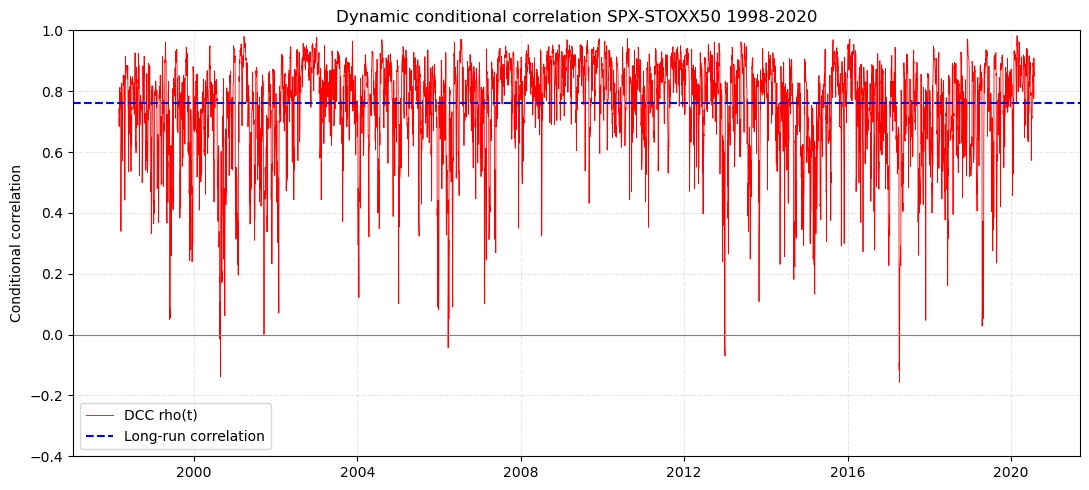

In [40]:
# THE EQUATIONS ARE BASED ON LECTURE_11_12a



# get our standardized returns z
Z     = np.column_stack([SPX_z, STOXX_z])      
dates = dcc_data.index
T, k  = Z.shape

# long-run target  q-bar  (covariance of z)
Qbar = np.cov(Z.T) # 2×2 matrix

# there are only 2 parameters in the DCC model, alpha and beta
def dcc_nll(params, z, Qbar):
    a, b = params   # alpha and beta

    # the structure is similar to GARCH(1,1) recursion, so we use the same logic for the penalty 
    if a <= 0 or b <= 0 or a + b > 0.999:
        return 1e10

    Q = Qbar.copy()
    nll = 0.0
    for t in range(len(z)):
        # Q recursion, as per page 161 in the course book (3.2 mean reverting correlation)
        Q = (1 - a - b) * Qbar + a * np.outer(z[t], z[t]) + b * Q
        
        rho = Q[0, 1] / np.sqrt(Q[0, 0] * Q[1, 1])

        denom = 1.0 - rho * rho
        if denom <= 0:          
            return 1e10

        z1, z2 = z[t]

        # bivariate normal log likelihood from page 163 in the course book (3.3 bivariate QMLE)
        nll += 0.5* (np.log(denom) + (z1*z1 + z2*z2 - 2.0*rho*z1*z2) / denom)

    return nll 

x0     = np.array([0.03, 0.94]) # sensible seed
bounds = [(1e-6, 1-1e-6), (1e-6, 1-1e-6)] # keep inside 0 and 1
res = minimize(dcc_nll, x0, args=(Z, Qbar),
               method="L-BFGS-B", bounds=bounds)
dcc_alpha, dcc_beta = res.x # get the parameters from the optimisation results

print(f"alpha = {dcc_alpha:.4f},  beta = {dcc_beta:.4f}")

# compute the matrices
def dcc_recursion(z, a, b, Qbar):
    T, _ = z.shape
    Q = Qbar.copy()
    R_path = np.empty((T, 2, 2))
    for t in range(T):
        Q = (1 - a - b) * Qbar + a * np.outer(z[t], z[t]) + b * Q
        invD   = np.diag(1.0 / np.sqrt(np.diag(Q)))
        R_path[t] = invD @ Q @ invD
    return R_path

R_t   = dcc_recursion(Z, dcc_alpha, dcc_beta, Qbar)
rho_t = R_t[:, 0, 1] # dynamic correlation series


# daily log returns for SPX and STOXX to get some rolling correlation
#daily_log = dcc_data[["SPX_R", "STOXX_R"]].copy()  
#rolling_corr = (daily_log["SPX_R"]
#                .rolling(window=250)
#                .corr(daily_log["STOXX_R"]))
#
#rolling_corr = rolling_corr.reindex(dates)


fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(dates, rho_t, label='DCC rho(t)', linewidth=0.6, color="red", alpha=1)
#ax.plot(dates, rolling_corr, color="black", linewidth=0.8,
#        label='250-day rolling corr.', alpha=0.8)

# calculate and plot long-run correlation
long_run_corr = Qbar[0, 1] / np.sqrt(Qbar[0, 0] * Qbar[1, 1])
ax.axhline(long_run_corr, color='blue', linestyle='--', linewidth=1.5, label='Long-run correlation', alpha=1)

ax.set(title=f'Dynamic conditional correlation SPX-STOXX50 {dcc_data.index.year[0]}-{dcc_data.index.year[-1]}',
       ylabel='Conditional correlation')
ax.set_ylim(-0.4, 1.0)
ax.axhline(0, color='grey', lw=0.8)
ax.legend()
ax.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


Based on the output from the DCC, it looks like the model did a good job. We tried just doing .corr() on the series and we get extremely similar values for the correlation. Also, very interesting to see that it varies so much over time. 


Very interesting to see that correlation increases towards 1 during crises.... 

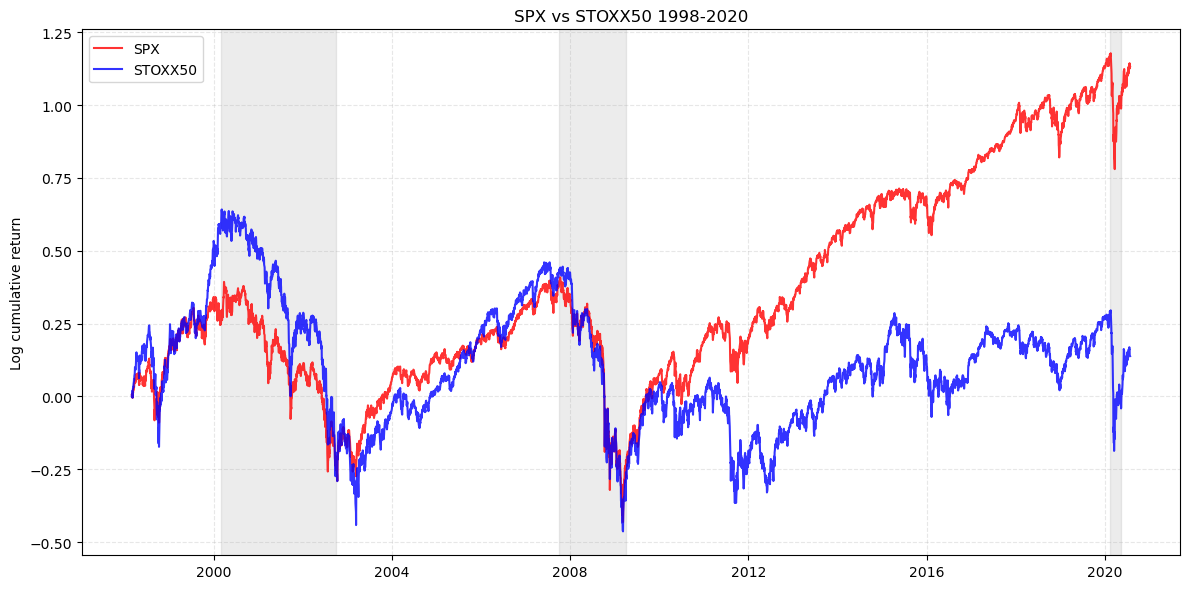

In [41]:
# LETS PLOT THE ACTUAL DATA WE HAVE ON THE INDICIES 
plt.figure(figsize=(12, 6))

# Calculate cumulative returns, logs are additivie so we do cumsum and not cumprod
cum_spx = (dcc_data["SPX_R"]).cumsum()
cum_stoxx = (dcc_data["STOXX_R"]).cumsum()

plt.plot(dcc_data.index, cum_spx, label="SPX", color='red', alpha=0.8)
plt.plot(dcc_data.index, cum_stoxx, label="STOXX50", color='blue', alpha=0.8)
plt.ylabel("Log cumulative return")
plt.title(f"SPX vs STOXX50 {dcc_data.index.year[0]}-{dcc_data.index.year[-1]}")
plt.axvspan(pd.Timestamp("2007-10-01"), pd.Timestamp("2009-03-31"), color="grey", alpha=0.15)
plt.axvspan(pd.Timestamp("2020-02-15"), pd.Timestamp("2020-05-15"), color="grey", alpha=0.15)
plt.axvspan(pd.Timestamp("2000-03-01"), pd.Timestamp("2002-10-01"), color="grey", alpha=0.15)
plt.xticks(rotation=0)
plt.legend()
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()

The data looks correct, e^1.2 = 3.3x your money (SPX). We are not sure if the data includes dividends, but 3.3x your money during this period sounds about right... Intersting to see that the STOXX has underperformed a lot..

## Step 4: TRADING STRATEGY

So based on the DCC correlation estimates and the return plot, it appears as if very high correlation can be a signal for bad times. Therefore, since we are estimating correlation, it would be interesting to test if we could use very high correlation as an exit signal. 


The trading strategy therefore becomes: Stay invested in both indices (equally weighted) but exit all positions once correlation goes above like 0.95. This way, we should be out-of-the-market when bad times comes. Slightly doding bad returns could potentially improve overall performance?

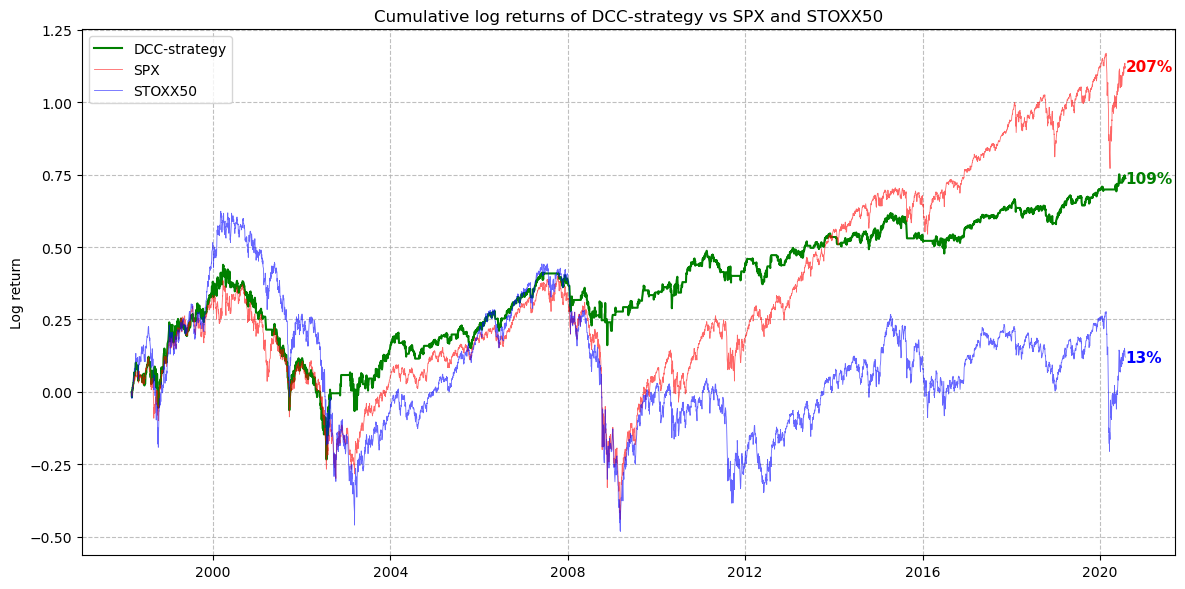

In [42]:

# align forecast with the prices
df_all = dcc_data.copy()
df_all["rho_f"] = pd.Series(rho_t, index=df_all.index).shift(1)
df_all = df_all.dropna()   # drop first row (no lagged forecast)

P1, P2   = df_all["SPX_close"].values, df_all["STOXX_close"].values
rho_f    = df_all["rho_f"].values
dates    = df_all.index

# maybe a bit arbitrary, but we set the thresholds for exit at 0.9
# we only consider positive values for correlation, and not the absolute value
HIGH_EXIT = 0.91
LOW_ENTRY = rho_f.mean() # safe to re-enter the market when correlation is coming down to its average 

# lets just say we have 100k in capital 
# WE ARE ASSUMING EUR/USD = 1.000
INITIAL_CAP = 100_000.0 # so we have 100k in capital
LONG_LEG    = INITIAL_CAP / 2 # we do a 50/50 split between SPX and STOXX

# just some accounting here
# when we have not invested, the capital is just sitting in cash
# so we start with 100k in cash, and when we do the first trade, then -100k cash +100k securities 
cash     = INITIAL_CAP

#indicator for if we are currently engaged in a trade
# 0 = flat, 1 = long-long (both SPX and STOXX)
position = 0    # 0 = flat, 1 = long-long
qty1 = qty2 = 0.0   # # shares/contracts of SPX and STOXX 

records = []

for t, dt in enumerate(dates):
    corr   = rho_f[t]
    action = None

    # ENTRY: correlation low enough 
    if position == 0 and corr <= LOW_ENTRY:
        qty1 = LONG_LEG / P1[t]    # shares/contracts of SPX
        qty2 = LONG_LEG / P2[t]    # shares/contracts of STOXX
        cash -= (qty1 * P1[t] + qty2 * P2[t])
        position = 1
        action = "ENTER" # log this in our "trading book"

    # EXIT: correlation very high (0.9)
    elif position == 1 and corr >= HIGH_EXIT:
        cash += (qty1 * P1[t] + qty2 * P2[t])
        qty1 = qty2 = 0.0
        position = 0
        action = "EXIT"

    # value all the positions at current prices
    mv_spx   = qty1 * P1[t]
    mv_stoxx = qty2 * P2[t]
    pf_val   = cash + mv_spx + mv_stoxx

    # weights for diagnostics (might be useful for portfolio analysis)
    total_not = abs(mv_spx) + abs(mv_stoxx)
    w_spx   = mv_spx/total_not if total_not else 0.0
    w_stoxx = mv_stoxx/total_not if total_not else 0.0

    # just add all data, we might need some of it later
    records.append({
        "date":        dt,
        "action":      action,
        "corr":        corr,
        "price_spx":   P1[t],
        "price_stoxx": P2[t],
        "qty_spx":     qty1 if position else 0.0,
        "qty_stoxx":   qty2 if position else 0.0,
        "weight_spx":  w_spx,
        "weight_stoxx":w_stoxx,
        "cash":        cash,
        "portfolio":   pf_val
    })

# store all the results
df = pd.DataFrame(records).set_index("date").sort_index()

# compute the PnL and the MOM multiple 
df["pnl"] = df["portfolio"] - INITIAL_CAP
df["strat_mom"] = df["portfolio"] / INITIAL_CAP

# create a new df since we are creating returns which introduces NaNs
dcc_final = pd.DataFrame(index=df.index)
dcc_final["pf"] = df["portfolio"]
dcc_final["spx"] = df["price_spx"]
dcc_final["stoxx"] = df["price_stoxx"]
dcc_final["PF"] = np.log(dcc_final["pf"] / dcc_final["pf"].iloc[0])
dcc_final["SPX"] = np.log(dcc_final["spx"] / dcc_final["spx"].iloc[0])
dcc_final["STOXX"] = np.log(dcc_final["stoxx"] / dcc_final["stoxx"].iloc[0])

    # calculate cumulative returns
dcc_final["PF_cumret"] = (dcc_final["PF"]).cumsum()
dcc_final["SPX_cumret"] = (1 + dcc_final["SPX"]).cumsum()
dcc_final["STOXX_cumret"] = (1 + dcc_final["STOXX"]).cumsum()
dcc_final["transaction"] = df["action"].fillna(method="ffill").fillna("NONE")
dcc_final = dcc_final.dropna()


#buy_signals = dcc_final[df["action"] == "ENTER"]
#sell_signals = dcc_final[df["action"] == "EXIT"]"

plt.figure(figsize=(12,6))
plt.plot(dcc_final.index, dcc_final["PF"],   label="DCC-strategy", color="green", alpha=1, lw=1.5)
plt.plot(dcc_final.index, dcc_final["SPX"], label="SPX", color="red", alpha=0.6, lw=0.6)
plt.plot(dcc_final.index, dcc_final["STOXX"], label="STOXX50", color="blue", alpha=0.6, lw=0.6)

#plt.scatter(buy_signals.index, buy_signals["PF"], marker="^", color="black", label="Buy (ENTER)", zorder=5)
#plt.scatter(sell_signals.index, sell_signals["PF"], marker="v", color="orange", label="Sell (EXIT)", zorder=5)

for col, color, label in [("PF", "green", "Strategy"), ("SPX", "red", "SPX"), ("STOXX", "blue", "STOXX50")]:
    final_logret = dcc_final[col].iloc[-1]
    total_return = np.exp(final_logret) - 1
    plt.text(
        dcc_final.index[-1], 
        dcc_final[col].iloc[-1], 
        f"{total_return*100:.0f}%", 
        color=color, 
        fontsize=11, 
        va="center", 
        ha="left", 
        fontweight="bold"
    )

plt.title("Cumulative log returns of DCC-strategy vs SPX and STOXX50")
plt.ylabel("Log return")
plt.legend(loc="upper left")
plt.grid(alpha=0.8, ls="--")
plt.tight_layout()
plt.show()


### Please note: We have optimised the GARCH parameters on the full sample, i.e., not divided between in and out-of-sample. This is an error on our side. We recognise this error and realise that it would have been better to estimate all parameters on an expanding window.

In [43]:
N = 252  # trading days per year

# calculate some metrics to see how well the strategy performed
# what is the risk-free rate though? now we assume 0%
results = []
for col, label in [("PF", "Strategy"), ("SPX", "SPX"), ("STOXX", "STOXX50")]:

    daily_logret = dcc_final[col].diff().dropna()
    ann_logret = daily_logret.mean() * N
    ann_vol = daily_logret.std() * np.sqrt(N)
    sharpe = ann_logret / ann_vol if ann_vol != 0 else np.nan
    ann_simple = np.exp(ann_logret) - 1
    results.append((label, ann_simple, ann_vol, sharpe))

# the moment of truth
print(f"{'Series':<10} {'Ann.Return':>12} {'Ann.Vol':>12} {'Sharpe':>8}")
for label, ann_simple, ann_vol, sharpe in results:
    print(f"{label:<10} {ann_simple:12.2%} {ann_vol:12.2%} {sharpe:8.2f}")

Series       Ann.Return      Ann.Vol   Sharpe
Strategy          3.40%       11.56%     0.29
SPX               5.23%       18.62%     0.27
STOXX50           0.55%       23.86%     0.02


## Step 5: Simualting Var and ES

In [44]:
# IGNORE THIS CELL
# IGNORE THIS CELL
# IGNORE THIS CELL


#Spx_parm = SPX_results.x
#STOXX_optimal_parameters = STOXX_results.x
#dcc_alpha, dcc_beta = res.x


# lets unpack all the parameters for SPX and STOXX
omega_stoxx, alpha_stoxx, beta_stoxx, mu_stoxx = LL_out_stoxx.x
omega_spx, alpha_spx, beta_spx, mu_spx = LL_out_spx.x

# get the DCC parameters
mc_alpha, mc_beta = res.x 

print(f"SPX Omega: {omega_spx:.6f}, Alpha: {alpha_spx:.4f}, Beta: {beta_spx:.4f}, Mu: {mu_spx:.6f}")    
print(f"STOXX Omega: {omega_stoxx:.6f}, Alpha: {alpha_stoxx:.4f}, Beta: {beta_stoxx:.4f}, Mu: {mu_stoxx:.6f}")


print(f"DCC ALPHA: {mc_alpha:.4f}")
print(f"DCC BETA: {mc_beta:.4f}")




SPX Omega: 0.000001, Alpha: 0.1117, Beta: 0.8780, Mu: 0.000580
STOXX Omega: 0.000001, Alpha: 0.0784, Beta: 0.9174, Mu: 0.000297
DCC ALPHA: 0.2195
DCC BETA: 0.7590


So, for the Monte Carlo simulation we need the variance process to follow GARCH. The RealGARCH is too hard to include in the simulation, so for simplicity, we just run a GARCH(1,1) to get the parameters omega, alpha, and beta.


The code is from the professor. 

In [45]:
# GARCH(1,1) JUST TO GET PARAMATERS FOR THE MONTE CARLO RECURSION 
# we are simplifying things here but should be fine for the exercise

# First define the returns
spx_returns = dcc_final["SPX"].diff().dropna()
stoxx_returns = dcc_final["STOXX"].diff().dropna()

# Likelihood
def garch_loglik_filter(para, returns):
    omega, alpha, beta, mu = para
    T = len(returns)

    h = np.empty(T + 1)
    z = np.empty(T)

    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        loglik = -1e9
        return {"loglik": loglik}

    h[0] = omega / (1 - alpha - beta)
    z[0] = (returns[0] - mu) / np.sqrt(h[0])

    for t in range(1, T):
        h[t] = omega + alpha * h[t-1] * z[t-1]**2 + beta * h[t-1]
        z[t] = (returns[t] - mu) / np.sqrt(h[t])

    h[T] = omega + alpha * h[T-1] * z[T-1]**2 + beta * h[T-1]

    loglik = -(T / 2) * np.log(2 * np.pi) - 0.5 * np.sum(np.log(h[:T])) - 0.5 * np.sum(z**2)
    
    return {"loglik": loglik, "cond_var": h, "shocks": z}  

# Wrapper for optimizer
def neg_GARCH_LL(para, returns):
    return -garch_loglik_filter(para, returns)["loglik"]

# Bounds
bounds = [
    (1e-16, None),  # omega > 0
    (0, 1),         # alpha in [0,1]
    (0, 1),         # beta in [0,1]
    (None, None)    # mu unrestricted
]

para0 = np.array([1e-6, 0.105, 0.8, 1e-4])

LL_out_spx = minimize(neg_GARCH_LL, para0, args=(spx_returns,), method='Nelder-Mead', bounds=bounds)
omega_spx, alpha_spx, beta_spx, mu_spx = LL_out_spx.x

LL_out_stoxx = minimize(neg_GARCH_LL, para0, args=(stoxx_returns,), method='Nelder-Mead', bounds=bounds)
omega_stoxx, alpha_stoxx, beta_stoxx, mu_stoxx = LL_out_stoxx.x

print(f"GARCH(1,1) parameters SPX: omega={omega_spx:.6f}, alpha={alpha_spx:.6f}, beta={beta_spx:.6f}, mu={mu_spx:.6f}")
print(f"GARCH(1,1) parameters STOXX: omega={omega_stoxx:.6f}, alpha={alpha_stoxx:.6f}, beta={beta_stoxx:.6f}, mu={mu_stoxx:.6f}")


GARCH(1,1) parameters SPX: omega=0.000001, alpha=0.111749, beta=0.878157, mu=0.000578
GARCH(1,1) parameters STOXX: omega=0.000003, alpha=0.100183, beta=0.888106, mu=0.000503


Now we have omega, alpha, and beta. 


 WE WILL HARDCODE THESE PARAMETERS IN THE VARIANCE RECURSION INSIDE THE MONTE CARLO SIMULATION

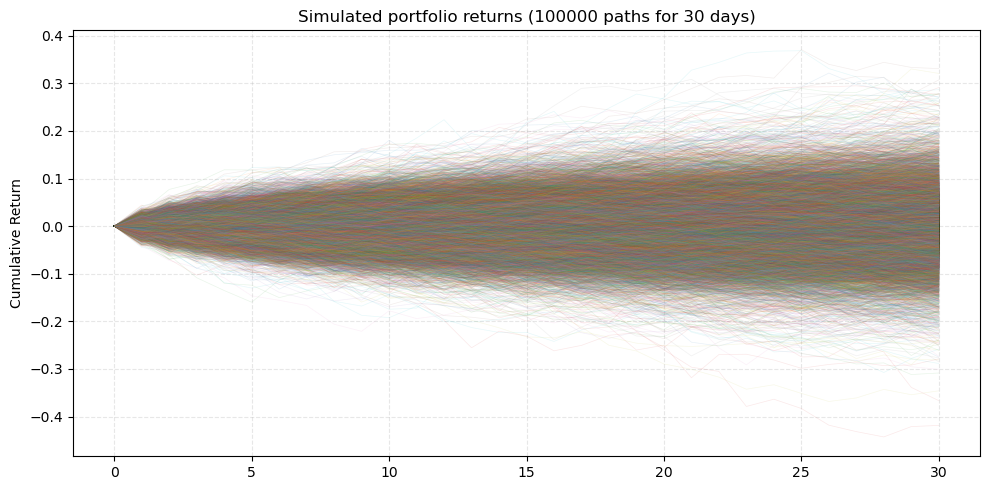

1-day 1% VaR: 0.02597
5-day 1% VaR: 0.06165


In [46]:
# now lets run the Monte Carlo simulation

# we do N = 100k and T = 30 days
N = 100_000      # number of simulated paths
T = 30           # number of days to simulate
weights = np.array([0.5, 0.5])  # ASSUMPTION: equal weight portfolio

# so we need to get the output from the DCC model
# we are kind of mixing GARCH models here 

# so basically, we previously used the RealGARCH(1,1), but to simplify things, we now use the GARCH(1,1) for the simulation
last_h_spx = SPX_h[-1]
last_h_stoxx = STOXX_h[-1]
last_z = np.array([SPX_z[-1], STOXX_z[-1]])
last_Q = Qbar.copy()
Q_path = []

# store the returns here
portfolio_returns = np.zeros((T, N))

# outer loop for the Monte Carlo simulation
# we are simulating N paths
for i in range(N):
    h_spx = last_h_spx
    h_stoxx = last_h_stoxx
    Q = last_Q.copy()
    z_prev = last_z.copy()
    
    port_ret = []

    # inner loop for the T days of simulation
    # we are simulating T days of returns
    for t in range(T):
        # DCC part
        Q = (1 - mc_alpha - mc_beta) * Qbar + mc_alpha * np.outer(z_prev, z_prev) + mc_beta * Q
        D_inv = np.diag(1.0 / np.sqrt(np.diag(Q)))
        R = D_inv @ Q @ D_inv
        rho = R[0, 1]

        sigma_spx = np.sqrt(h_spx)
        sigma_stoxx = np.sqrt(h_stoxx)
        cov = rho * sigma_spx * sigma_stoxx

        H = np.array([
            [h_spx, cov],
            [cov, h_stoxx]
        ])

        # the shocks
        z = np.random.randn(2)
        eps = np.linalg.cholesky(R) @ z  # correlated standard normals
        r_spx = sigma_spx * eps[0]
        r_stoxx = sigma_stoxx * eps[1]
        r_vec = np.array([r_spx, r_stoxx])
        port_ret.append(weights @ r_vec)

        # here we have the GARCH recursiom with hardcoded parameters
        h_spx = omega_spx + alpha_spx * r_spx**2 + beta_spx * h_spx
        h_stoxx = omega_stoxx + alpha_stoxx * r_stoxx**2 + beta_stoxx * h_stoxx
        z_prev = np.array([r_spx / np.sqrt(h_spx), r_stoxx / np.sqrt(h_stoxx)])



    portfolio_returns[:, i] = port_ret


cum_ret = portfolio_returns.cumsum(axis=0)
var_1d = -np.quantile(portfolio_returns[0, :], 0.01)
var_5d = -np.quantile(cum_ret[4, :], 0.01)

cum_ret_plot = np.vstack([np.zeros(N), cum_ret])  # shape (T+1, N)



plt.figure(figsize=(10, 5))
# include (N) lines in the graph (scale down to make it easier to compute)
# now set at 20k to make it faster
for i in range(20_000):
    plt.plot(cum_ret_plot[:, i], lw=0.5, alpha=0.1)

plt.title(f"Simulated portfolio returns ({N} paths for {T} days)")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.3, ls="--")
plt.tight_layout()
plt.show()


print(f"1-day 1% VaR: {var_1d:.5f}")
print(f"5-day 1% VaR: {var_5d:.5f}")